In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/worm-nueron/Worm_neuron_raw_data.h5


In [2]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 102.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 81.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 96.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.

In [4]:
pip install scanpy matplotlib seaborn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
import random
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


2025-08-11 14:46:29.323213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754923589.681272      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754923589.784986      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


=== Dataset Overview ===
Shape (Cells x Genes): (4186, 13488)
First 5 Cell IDs: ['cele-001-001.AACTACGGCT', 'cele-001-001.GAGGCTTATT', 'cele-001-001.CTGATCGACC', 'cele-001-001.CCTACGGCAA', 'cele-001-001.CGCTAACCGT']
First 5 Gene Names: ['WBGene00000001', 'WBGene00000002', 'WBGene00000003', 'WBGene00000004', 'WBGene00000006']

Sparsity of expression matrix: 98.62%

=== Summary statistics for first 5 genes ===
                    mean       std  min  25%  50%  75%  max
WBGene00000001  0.005495  0.088629  0.0  0.0  0.0  0.0  2.0
WBGene00000002  0.007645  0.119493  0.0  0.0  0.0  0.0  3.0
WBGene00000003  0.005972  0.103523  0.0  0.0  0.0  0.0  3.0
WBGene00000004  0.026039  0.186883  0.0  0.0  0.0  0.0  3.0
WBGene00000006  0.069040  0.399835  0.0  0.0  0.0  0.0  8.0


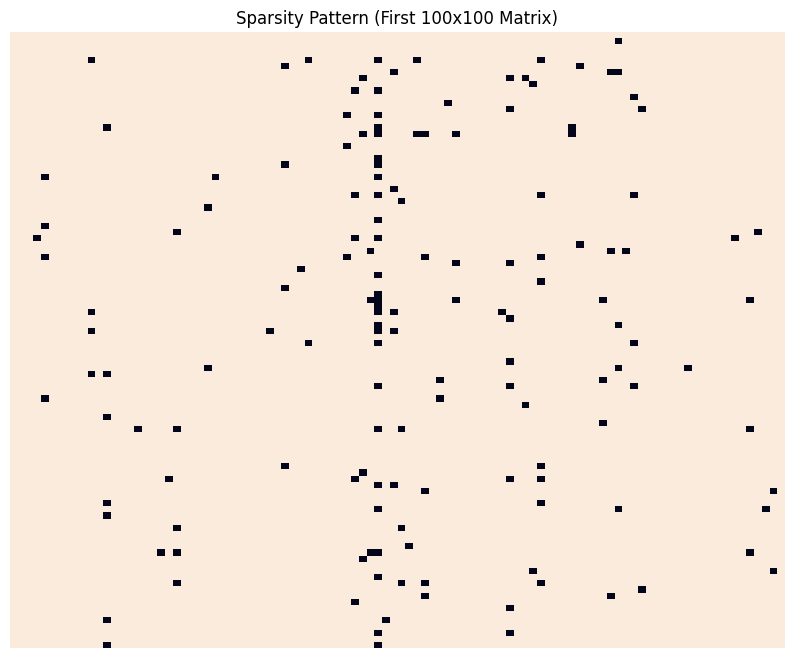

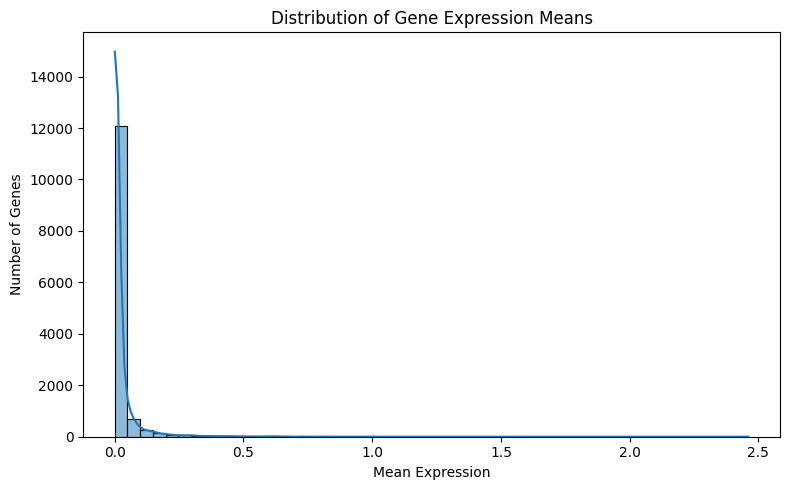


=== Class Distribution (First 10 Classes) ===
label
1.0      842
2.0      334
3.0     1015
4.0      443
5.0      400
6.0      314
7.0      305
8.0      224
9.0      239
10.0      70
Name: count, dtype: int64


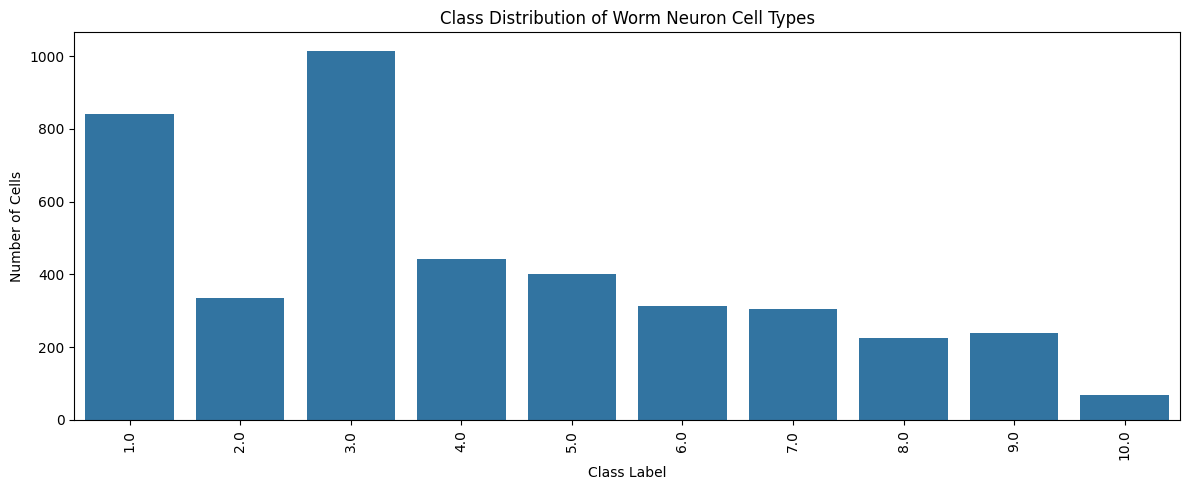

In [6]:
file_path = "/kaggle/input/worm-nueron/Worm_neuron_raw_data.h5"
with h5py.File(file_path, 'r') as f:
    X = f['X'][:]  # Expression matrix
    Y = f['Y'][:]  # True labels (cell types)
    cell_names = [x.decode() for x in f['cell_name'][:]]
    gene_names = [x.decode() for x in f['gene_name'][:]]

df = pd.DataFrame(X, index=cell_names, columns=gene_names)
adata = sc.AnnData(df)
adata.write("worm_neuron_data.h5ad")

label_series = pd.Series(Y, index=cell_names, name="label")
adata.obs["label"] = label_series

adata.write("worm_neuron_data_labeled.h5ad")

# Summary Statistics
print("=== Dataset Overview ===")
print(f"Shape (Cells x Genes): {adata.shape}")
print(f"First 5 Cell IDs: {adata.obs_names[:5].tolist()}")
print(f"First 5 Gene Names: {adata.var_names[:5].tolist()}")

# Sparsity Check
num_zeros = (adata.X == 0).sum()
total = adata.X.size
sparsity = num_zeros / total
print(f"\nSparsity of expression matrix: {sparsity * 100:.2f}%")

#Per-gene summary 
summary_stats = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\n=== Summary statistics for first 5 genes ===")
print(summary_stats.head())

# Sparsity Heatmap
subset = df.iloc[:100, :100]
plt.figure(figsize=(10, 8))
sns.heatmap((subset == 0), cbar=False, xticklabels=False, yticklabels=False)
plt.title("Sparsity Pattern (First 100x100 Matrix)")
plt.show()

# Gene Mean Distribution 
gene_means = df.mean(axis=0)
plt.figure(figsize=(8, 5))
sns.histplot(gene_means, bins=50, kde=True)
plt.title("Distribution of Gene Expression Means")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# Class Imbalance Check 
label_counts = adata.obs["label"].value_counts().sort_index()
label_counts.index = label_counts.index.astype(str)

print("\n=== Class Distribution (First 10 Classes) ===")
print(label_counts.head(10))

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution of Worm Neuron Cell Types")
plt.xlabel("Class Label")
plt.ylabel("Number of Cells")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


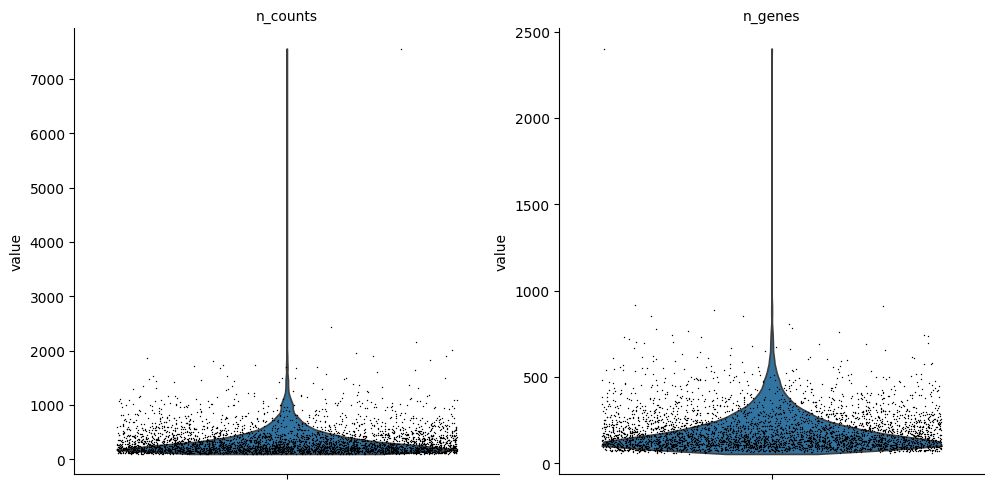

Before filtering: (4186, 13488)
After filtering: (1351, 8780)
HVGs selected: 2000


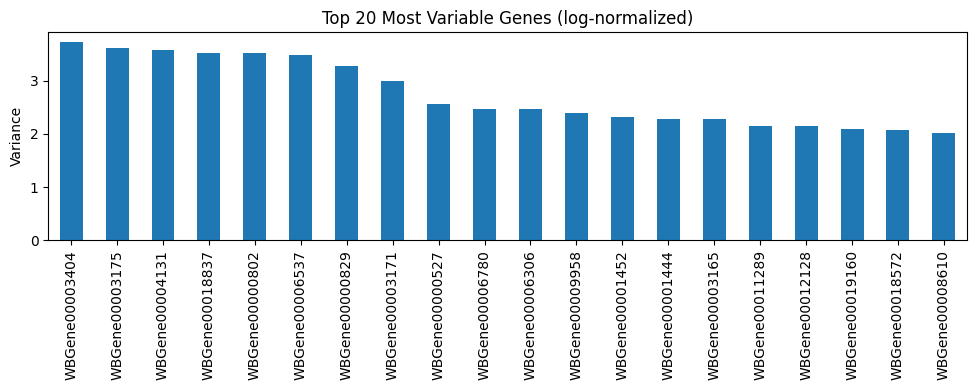

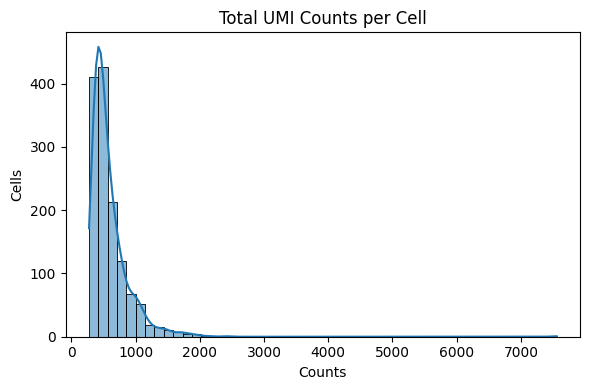

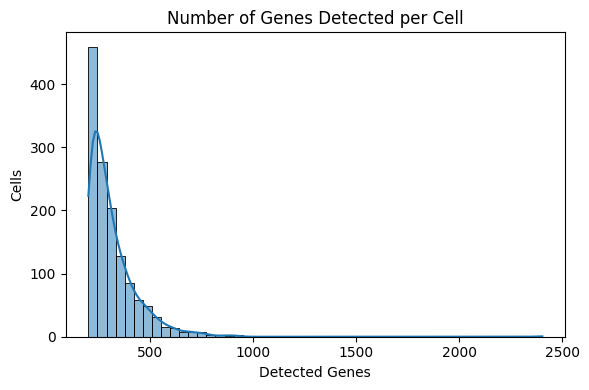

 Filtered raw dataset saved for SCDCC
 Log-normalized dataset saved for exploratory analysis


In [7]:
#  Loading raw AnnData object 
adata = sc.read("worm_neuron_data.h5ad")

# === Step 1: Calculate QC metrics ===
adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if sparse.issparse(adata.X) else adata.X.sum(axis=1)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=0)

# Visualizing QC metrics 
sc.pl.violin(adata, ['n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

# Filtering
print(f"Before filtering: {adata.shape}")
sc.pp.filter_cells(adata, min_counts=100)     # more lenient
sc.pp.filter_cells(adata, min_genes=200)      # more lenient
sc.pp.filter_genes(adata, min_cells=3)
print(f"After filtering: {adata.shape}")

#Saving filtered raw counts
adata_raw = adata.copy()
adata_raw.write("worm_neuron_raw_for_scdcc.h5ad")

# log-normalizing 
adata_eda = adata.copy()
sc.pp.normalize_total(adata_eda, target_sum=1e4)
sc.pp.log1p(adata_eda)

# Identifying highly variable genes \
sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor='seurat', inplace=True)
print(f"HVGs selected: {adata_eda.var.highly_variable.sum()}")

# Ploting top HVGs 
top_hvg = adata_eda[:, adata_eda.var.highly_variable].to_df().var().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 4))
top_hvg.plot(kind='bar')
plt.title("Top 20 Most Variable Genes (log-normalized)")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

# Ploting UMI count distribution 
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_counts'], bins=50, kde=True)
plt.title("Total UMI Counts per Cell")
plt.xlabel("Counts")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Ploting gene detection per cell 
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Detected Genes")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

adata_eda.write("worm_neuron_eda_log_norm.h5ad")


print(" Filtered raw dataset saved for SCDCC")
print(" Log-normalized dataset saved for exploratory analysis")


In [8]:

from sklearn.model_selection import train_test_split


adata_raw = sc.read("worm_neuron_raw_for_scdcc.h5ad")      
adata_eda = sc.read("worm_neuron_eda_log_norm.h5ad")       

#Subset to HVGs (2000 genes) for constraint set :
if "highly_variable" not in adata_eda.var.columns:
    raise ValueError("HVGs not found. Run highly_variable_genes() before this step.")
adata_eda = adata_eda[:, adata_eda.var.highly_variable].copy()
print(f" HVG Subset Shape: {adata_eda.shape}")

# Sanity check: cell alignment 
assert np.all(adata_raw.obs_names == adata_eda.obs_names), "Mismatch in cell IDs!"

# 80/10/10 split 
indices = np.arange(adata_raw.n_obs)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

# Creating subset AnnData objects 
adata_raw_train = adata_raw[train_idx].copy()
adata_raw_val   = adata_raw[val_idx].copy()
adata_raw_test  = adata_raw[test_idx].copy()

adata_eda_train = adata_eda[train_idx].copy()
adata_eda_val   = adata_eda[val_idx].copy()
adata_eda_test  = adata_eda[test_idx].copy()

#Attaching true labels from original HDF5
with h5py.File("/kaggle/input/worm-nueron/Worm_neuron_raw_data.h5", "r") as f:
    Y_full = f['Y'][:]
    all_cell_names = [x.decode() for x in f['cell_name'][:]]

cell_to_label = dict(zip(all_cell_names, Y_full))

# Attaching labels to RAW splits 
for ad, name in zip(
    [adata_raw_train, adata_raw_val, adata_raw_test],
    ["Train", "Val", "Test"]
):
    ad.obs["label"] = ad.obs_names.map(cell_to_label)
    missing = ad.obs["label"].isna().sum()
    print(f" Labels attached to {name} split. Missing: {missing}")

# Attaching labels to HVG splits 
for ad_hvg, name in zip(
    [adata_eda_train, adata_eda_val, adata_eda_test],
    ["Train", "Val", "Test"]
):
    ad_hvg.obs["label"] = ad_hvg.obs_names.map(cell_to_label)
    missing = ad_hvg.obs["label"].isna().sum()
    print(f" Labels attached to HVG {name} split. Missing: {missing}")

#  Printing summary 
print("\n=== Raw (SCDCC) Splits ===")
print(f"Train: {adata_raw_train.shape}, {adata_raw_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_raw_val.shape}, {adata_raw_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_raw_test.shape}, {adata_raw_test.obs_names[:3].tolist()}")

print("\n=== HVG (Constraints) Splits ===")
print(f"Train: {adata_eda_train.shape}, {adata_eda_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_eda_val.shape}, {adata_eda_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_eda_test.shape}, {adata_eda_test.obs_names[:3].tolist()}")

# Saving all datasets 
adata_raw_train.write("scdcc_raw_train.h5ad")
adata_raw_val.write("scdcc_raw_val.h5ad")
adata_raw_test.write("scdcc_raw_test.h5ad")

adata_eda_train.write("constraints_hvg_train.h5ad")
adata_eda_val.write("constraints_hvg_val.h5ad")
adata_eda_test.write("constraints_hvg_test.h5ad")

print("\n All data splits saved with true labels attached.")


 HVG Subset Shape: (1351, 2000)
 Labels attached to Train split. Missing: 0
 Labels attached to Val split. Missing: 0
 Labels attached to Test split. Missing: 0
 Labels attached to HVG Train split. Missing: 0
 Labels attached to HVG Val split. Missing: 0
 Labels attached to HVG Test split. Missing: 0

=== Raw (SCDCC) Splits ===
Train: (1080, 8780), ['cele-007-070.GTTGAACGCA', 'cele-002-035.CTACGGTAGC', 'cele-009-021.CCAGGCCGCA']
Val:   (135, 8780), ['cele-008-073.ACGATAAGCG', 'cele-009-035.TATATGAAGT', 'cele-008-045.ACGATACCGG']
Test:  (136, 8780), ['cele-006-069.TGGCCGCAAT', 'cele-009-030.TGGTCCAGTC', 'cele-006-085.ACCAGCCTTA']

=== HVG (Constraints) Splits ===
Train: (1080, 2000), ['cele-007-070.GTTGAACGCA', 'cele-002-035.CTACGGTAGC', 'cele-009-021.CCAGGCCGCA']
Val:   (135, 2000), ['cele-008-073.ACGATAAGCG', 'cele-009-035.TATATGAAGT', 'cele-008-045.ACGATACCGG']
Test:  (136, 2000), ['cele-006-069.TGGCCGCAAT', 'cele-009-030.TGGTCCAGTC', 'cele-006-085.ACCAGCCTTA']

 All data splits save

In [9]:
#Loading labeled AnnData 
adata = sc.read("scdcc_raw_train.h5ad")

#  Check for labels 
if 'label' not in adata.obs.columns:
    raise ValueError("adata.obs['label'] not found. Please attach true labels before running this.")

#Grouping cells by labels
label_groups = adata.obs.groupby('label').groups  # label → list of cell IDs

user_input = input(" Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000): ")
constraint_sizes = [int(x.strip()) for x in user_input.split(",") if x.strip().isdigit()]
print(f"\n Will generate constraints for TOTAL sizes: {constraint_sizes}")

def generate_constraints(label_groups, total_constraints, seed=42):
    random.seed(seed)
    labels = list(label_groups.keys())
    must_link = set()
    cannot_link = set()
    n_ml = total_constraints // 2 + total_constraints % 2  # if odd, must-link gets extra
    n_cl = total_constraints // 2

    # Must-link: pairs from same class
    while len(must_link) < n_ml:
        label = random.choice(labels)
        members = list(label_groups[label])
        if len(members) >= 2:
            pair = tuple(sorted(random.sample(members, 2)))
            must_link.add(pair)

    # Cannot-link: pairs from different classes
    while len(cannot_link) < n_cl:
        l1, l2 = random.sample(labels, 2)
        if l1 == l2:
            continue
        i = random.choice(label_groups[l1])
        j = random.choice(label_groups[l2])
        pair = tuple(sorted((i, j)))
        if pair not in must_link:  # Don't allow overlap
            cannot_link.add(pair)

    return list(must_link), list(cannot_link)

# Generating and storing constraints in-memory
constraints = {}

for total_size in constraint_sizes:
    ml, cl = generate_constraints(label_groups, total_constraints=total_size)
    constraints[total_size] = {
        "must_link": ml,
        "cannot_link": cl
    }
    print(f"\n Constraints generated for total size {total_size}:")
    print(f"    Must-link pairs:    {len(ml)}")
    print(f"    Cannot-link pairs:  {len(cl)}")



 Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000):  0,1000,2000,3000,4000,5000,6000



 Will generate constraints for TOTAL sizes: [0, 1000, 2000, 3000, 4000, 5000, 6000]

 Constraints generated for total size 0:
    Must-link pairs:    0
    Cannot-link pairs:  0

 Constraints generated for total size 1000:
    Must-link pairs:    500
    Cannot-link pairs:  500

 Constraints generated for total size 2000:
    Must-link pairs:    1000
    Cannot-link pairs:  1000

 Constraints generated for total size 3000:
    Must-link pairs:    1500
    Cannot-link pairs:  1500

 Constraints generated for total size 4000:
    Must-link pairs:    2000
    Cannot-link pairs:  2000

 Constraints generated for total size 5000:
    Must-link pairs:    2500
    Cannot-link pairs:  2500

 Constraints generated for total size 6000:
    Must-link pairs:    3000
    Cannot-link pairs:  3000


In [10]:
def check_constraints_validity(adata, constraints):
    for total_size, constraint_dict in constraints.items():
        must_link = constraint_dict['must_link']
        cannot_link = constraint_dict['cannot_link']

        # Checking must-link constraints
        for i, j in must_link:
            label_i = adata.obs.loc[i, 'label']
            label_j = adata.obs.loc[j, 'label']
            if label_i != label_j:
                print(f"Error in must-link pair ({i}, {j}): labels differ ({label_i} vs {label_j})")

        # Checking cannot-link constraints
        for i, j in cannot_link:
            label_i = adata.obs.loc[i, 'label']
            label_j = adata.obs.loc[j, 'label']
            if label_i == label_j:
                print(f"Error in cannot-link pair ({i}, {j}): labels are the same ({label_i})")

    print(" Constraint validity check done.")

# Runing validity check on generated constraints
check_constraints_validity(adata, constraints)


 Constraint validity check done.


 KMeans Baseline Evaluation
 ARI: 0.4908
 NMI: 0.7275
 CA:  0.7279


... storing 'kmeans_pred' as categorical



 PCA & UMAP of KMeans Predictions


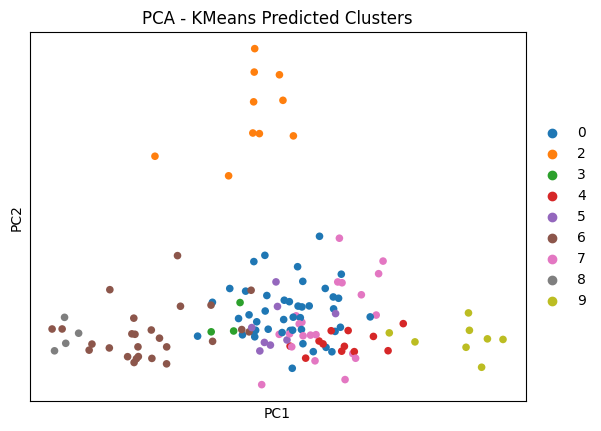

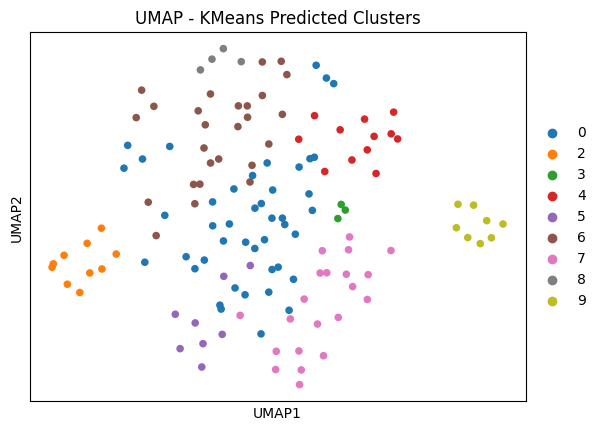

In [11]:
#  Loading HVG log-normalized training and test data 
adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad")  

# Extracting matrices and true labels 
X_train = adata_train.X
X_test = adata_test.X
true_labels = adata_test.obs["label"].astype(int).values
n_clusters = len(np.unique(true_labels))

# Training KMeans on training set 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

# Predicting test labels
pred_labels = kmeans.predict(X_test)

# Clustering Accuracy
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

# Compute Metrics 
ari_kmeans = adjusted_rand_score(true_labels, pred_labels)
nmi_kmeans = normalized_mutual_info_score(true_labels, pred_labels)
ca_kmeans = clustering_accuracy(true_labels, pred_labels)

#  Saving results 
kmeans_results = {
    "ARI": ari_kmeans,
    "NMI": nmi_kmeans,
    "CA": ca_kmeans,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

# Printing metrics
print(" KMeans Baseline Evaluation")
print(f" ARI: {ari_kmeans:.4f}")
print(f" NMI: {nmi_kmeans:.4f}")
print(f" CA:  {ca_kmeans:.4f}")

# visualization 
adata_vis = adata_test.copy()
adata_vis.obs["true_label"] = pd.Series(true_labels, index=adata_vis.obs_names).astype(str)
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)

adata_vis = adata_test.copy()
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)


# Dimensionality Reduction 
sc.pp.pca(adata_vis, n_comps=50)
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)

# Visualizing predicted KMeans clusters
print("\n PCA & UMAP of KMeans Predictions")
sc.pl.pca(
    adata_vis,
    color="kmeans_pred",
    title="PCA - KMeans Predicted Clusters",
    size=120,
    show=True
)

sc.pl.umap(
    adata_vis,
    color="kmeans_pred",
    title="UMAP - KMeans Predicted Clusters",
    size=120,
    show=True
)



Training shape: (1080, 2000), Test shape: (136, 2000), Clusters: 10


I0000 00:00:1754923690.881361      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754923690.882111      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


🔧 Pretraining Autoencoder...
Epoch 1/50


I0000 00:00:1754923695.386723     128 service.cc:148] XLA service 0x2461b600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754923695.388196     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754923695.388217     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754923695.839588     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/5 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.2521

I0000 00:00:1754923697.421757     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - loss: 0.2548
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2434 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2339 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2299 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2287 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2256 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2225 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2178 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2138 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2075 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2021 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1981 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1977 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1951 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1936 
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

... storing 'dec_pred' as categorical


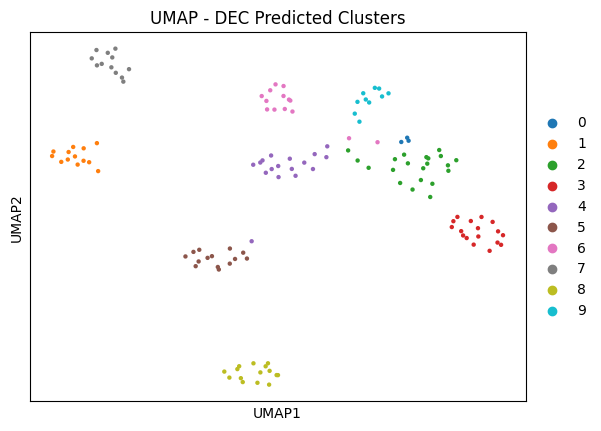

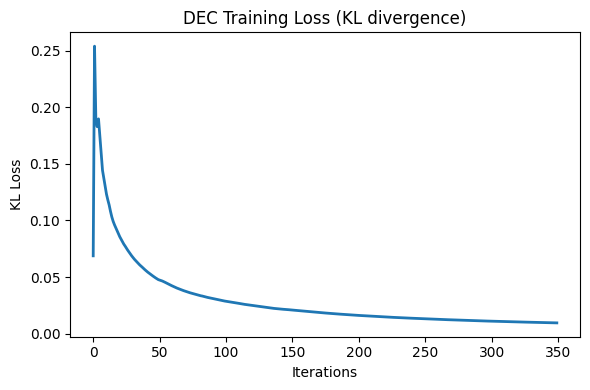

In [12]:

adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad")

X_train = adata_train.X.astype(np.float32)
X_test = adata_test.X.astype(np.float32)
true_labels = adata_test.obs["label"].astype(int).values
n_clusters = len(np.unique(true_labels))

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}, Clusters: {n_clusters}")

# Clustering Accuracy
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

#Autoencoder Definition & Pretrain
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoded = Dense(500, activation='relu')(input_layer)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
latent = Dense(encoding_dim, name='latent')(encoded)

decoded = Dense(2000, activation='relu')(latent)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=latent)

autoencoder.compile(optimizer='adam', loss='mse')
print("🔧 Pretraining Autoencoder...")
autoencoder.fit(X_train, X_train, batch_size=256, epochs=50, verbose=1)

# KMeans Init 
Z_train = encoder.predict(X_train)
Z_test = encoder.predict(X_test)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans.fit(Z_train)
cluster_centers = kmeans.cluster_centers_

#  Clustering Layer
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, initial_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = initial_weights

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters'
        )
        if self.initial_weights is not None:
            self.set_weights([self.initial_weights])
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        # Student’s t-distribution
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q **= (self.n_clusters + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
        return q

# Target Distribution
def target_distribution(q):
    weight = q ** 2 / np.sum(q, axis=0)
    return (weight.T / np.sum(weight, axis=1)).T

# Building DEC Model 
clustering_layer = ClusteringLayer(n_clusters, initial_weights=cluster_centers, name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.compile(optimizer='adam', loss='kld')

#KL Fine-tuning 
print(" Fine-tuning DEC with KL divergence...")
maxiter = 5000
update_interval = 50
tol = 1e-4
min_kl_updates = 2  # Stop after 2 consecutive below-tol
kl_no_change = 0
batch_size = 256
loss_history = []
index_array = np.arange(X_train.shape[0])

q = dec_model.predict(X_train, verbose=0)
p = target_distribution(q)
y_pred_last = q.argmax(1)

for ite in range(maxiter):
    if ite % update_interval == 0:
        q = dec_model.predict(X_train, verbose=0)
        p = target_distribution(q)
        y_pred = q.argmax(1)
        label_change_rate = np.mean(y_pred != y_pred_last)
        print(f"Iter {ite}, Label change rate: {label_change_rate:.5f}")
        if label_change_rate < tol:
            kl_no_change += 1
            if kl_no_change >= min_kl_updates:
                print(f"Converged (label change rate < tol for {min_kl_updates} consecutive intervals).")
                break
        else:
            kl_no_change = 0
        y_pred_last = y_pred
    # Batch update
    idx = np.random.choice(index_array, batch_size, replace=False)
    loss = dec_model.train_on_batch(X_train[idx], p[idx])
    loss_history.append(float(loss))

#  Evaluating on Test Set 
q_test = dec_model.predict(X_test)
pred_labels = q_test.argmax(1)
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ca = clustering_accuracy(true_labels, pred_labels)

print("\n DEC (with KL fine-tuning) Evaluation")
print(f" ARI: {ari:.4f}")
print(f" NMI: {nmi:.4f}")
print(f" CA:  {ca:.4f}")

# Saving results 
dec_results = {
    "ARI": ari,
    "NMI": nmi,
    "CA": ca,
    "true_labels": true_labels,
    "pred_labels": pred_labels,
    "kl_loss_history": loss_history,
}

#  UMAP Visualization 
adata_vis = adata_test.copy()
adata_vis.obsm["X_latent"] = encoder.predict(X_test)
adata_vis.obs["dec_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)
sc.pp.neighbors(adata_vis, use_rep="X_latent")
sc.tl.umap(adata_vis)
sc.pl.umap(adata_vis, color="dec_pred", title="UMAP - DEC Predicted Clusters", size=40)

#  KL Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(loss_history, lw=2)
plt.title("DEC Training Loss (KL divergence)")
plt.xlabel("Iterations")
plt.ylabel("KL Loss")
plt.tight_layout()
plt.show()


In [13]:


#  DEVICE SETUP 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  UTILS 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

class IndexedTensorDataset(TensorDataset):
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return (*data, idx)

def get_in_batch_pairs(batch_indices, constraint_pairs):
    batch_map = {idx: i for i, idx in enumerate(batch_indices)}
    pairs_in_batch = [
        (batch_map[i], batch_map[j])
        for i, j in constraint_pairs if i in batch_map and j in batch_map
    ]
    return pairs_in_batch

def contrastive_loss(z, must_link, cannot_link, margin=2.0, alpha=1.0, beta=5.0):
    loss_ml = 0.0
    loss_cl = 0.0
    eps = 1e-9
    if len(must_link) > 0:
        for i, j in must_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_ml += dist ** 2
        loss_ml = loss_ml / (len(must_link) + eps)
    if len(cannot_link) > 0:
        for i, j in cannot_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_cl += F.relu(margin - dist) ** 2
        loss_cl = loss_cl / (len(cannot_link) + eps)
    return alpha * loss_ml + beta * loss_cl

class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda
    def forward(self, x, pi, theta, mu):
        theta = torch.clamp(theta, min=self.eps)
        pi = torch.clamp(pi, min=self.eps, max=1.0 - self.eps)
        mu = torch.clamp(mu, min=self.eps)
        t1 = torch.lgamma(theta + self.eps) + torch.lgamma(x + 1.0) - torch.lgamma(x + theta + self.eps)
        t2 = (theta + x) * torch.log(1.0 + (mu / theta)) + x * (torch.log(theta + self.eps) - torch.log(mu + self.eps))
        nb_case = t1 + t2 - torch.log(1.0 - pi + self.eps)
        zero_case = -torch.log(pi + ((1.0 - pi) * torch.pow(theta / (theta + mu), theta)) + self.eps)
        result = torch.where(torch.lt(x, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * torch.sum(torch.square(pi))
        return torch.mean(result) + ridge

#  scDCC Network
class scDCC(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(scDCC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        self.pi_layer = nn.Linear(latent_dim, input_dim)
        self.theta_layer = nn.Parameter(torch.randn(input_dim))

    def forward(self, x):
        z = self.encoder(x)
        # Debug: check for NaNs/Infs in z
        if not torch.isfinite(z).all():
            print(" NaNs/Infs detected in latent z (forward)")
            print("z min/max:", z.min().item(), z.max().item())
            print(z)
            assert torch.isfinite(z).all()
        dec = self.decoder(z)
        dec = torch.clamp(dec, min=-10, max=10)  # <- CLAMP TO PREVENT OVERFLOW
        pi = torch.sigmoid(self.pi_layer(z))
        theta = F.softplus(self.theta_layer)
        mu = torch.exp(dec)
        for name, tensor in zip(["pi", "theta", "mu"], [pi, theta, mu]):
            if not torch.isfinite(tensor).all():
                print(f" NaNs/Infs in {name} (forward)")
                print(f"{name} min/max:", tensor.min().item(), tensor.max().item())
                print(tensor)
                assert torch.isfinite(tensor).all()
        return pi, theta, mu, z

#  Pretraining (ZINB autoencoder) 
def pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=150, batch_size=256, lr=1e-3, print_every=10):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            pi, theta, mu, _ = model(x)
            loss = loss_fn(x, pi, theta, mu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % print_every == 0 or epoch == 0:
            # Evaluate clustering metrics on train and val (latent -> KMeans)
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Pretrain] Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")

#  Training With Constraints 
def train_scdcc(
    model, X_train, X_val, must_link, cannot_link, train_labels, val_labels,
    epochs=300, batch_size=256, lr=1e-3, print_every=10, alpha=1.0, beta=5.0, margin=2.0
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    zinb_loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    dataset = IndexedTensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = int(np.ceil(X_tensor.shape[0] / batch_size))
    loss_curve = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            batch_indices = batch[1].cpu().numpy()
            ml_in = get_in_batch_pairs(batch_indices, must_link)
            cl_in = get_in_batch_pairs(batch_indices, cannot_link)
            pi, theta, mu, z = model(x)
            constr_loss = contrastive_loss(z, ml_in, cl_in, margin=margin, alpha=alpha, beta=beta)
            zinb_loss = zinb_loss_fn(x, pi, theta, mu)
            loss = zinb_loss + constr_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_curve.append(epoch_loss / num_batches)
        if (epoch+1) % print_every == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Fine-tune] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")
    return loss_curve

#   SCDCC Pipeline 
def run_full_scdcc_pipeline(
    X_train, X_val, X_test, train_labels, val_labels, test_labels, constraints_idx,
    latent_dims=[10, 20, 50], lrs=[1e-3, 5e-4],
    pretrain_epochs=150, train_epochs=300, n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0, tune_constraint_index=0
):
    final_results = {}
    constraint_sizes = sorted(list(constraints_idx.keys()))
    # --- Hyperparameter search on chosen constraint set ---
    hp_size = constraint_sizes[tune_constraint_index]
    must_link_hp = constraints_idx[hp_size]['must_link']
    cannot_link_hp = constraints_idx[hp_size]['cannot_link']
    print(f"\n Hyperparameter search on constraint size: {hp_size}")

    best_config = None
    best_ari = -1
    for latent_dim, lr in itertools.product(latent_dims, lrs):
        print(f"  Trying latent_dim={latent_dim}, lr={lr}")
        model = scDCC(input_dim=X_train.shape[1], latent_dim=latent_dim).to(device)
        pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs//2, lr=lr, print_every=pretrain_epochs//10)
        train_scdcc(model, X_train, X_val, must_link_hp, cannot_link_hp, train_labels, val_labels, epochs=train_epochs//2, lr=lr,
                    print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
        model.eval()
        with torch.no_grad():
            _, _, _, z_val = model(torch.tensor(X_val, dtype=torch.float32, device=device))
        pred_val = KMeans(n_clusters=len(np.unique(val_labels)), random_state=42).fit_predict(z_val.cpu().numpy())
        ari_val = adjusted_rand_score(val_labels, pred_val)
        print(f"     ➡ ARI-val: {ari_val:.4f}")
        if ari_val > best_ari:
            best_ari = ari_val
            best_config = (latent_dim, lr)
    print(f"\n Best config (latent_dim={best_config[0]}, lr={best_config[1]}) from constraint size {hp_size}.")

    # Runing all constraint sizes with the best config, N times 
    for size in constraint_sizes:
        print(f"\n=== SCDCC with constraint size: {size} ===")
        must_link = constraints_idx[size]['must_link']
        cannot_link = constraints_idx[size]['cannot_link']
        all_ari, all_nmi, all_ca = [], [], []
        z_tests = []
        pred_tests = []
        loss_curves = []
        for run in range(n_repeats):
            print(f"   Run {run+1}/{n_repeats}")
            model = scDCC(input_dim=X_train.shape[1], latent_dim=best_config[0]).to(device)
            pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs, lr=best_config[1], print_every=pretrain_epochs//10)
            loss_curve = train_scdcc(model, X_train, X_val, must_link, cannot_link, train_labels, val_labels, epochs=train_epochs, lr=best_config[1],
                        print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
            model.eval()
            with torch.no_grad():
                _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
            z_test = z_test.cpu().numpy()
            pred_labels = KMeans(n_clusters=len(np.unique(test_labels)), random_state=run).fit_predict(z_test)
            z_tests.append(z_test)
            pred_tests.append(pred_labels)
            loss_curves.append(loss_curve)
            ari = adjusted_rand_score(test_labels, pred_labels)
            nmi = normalized_mutual_info_score(test_labels, pred_labels)
            ca = clustering_accuracy(test_labels, pred_labels)
            print(f"     ARI: {ari:.4f}, NMI: {nmi:.4f}, CA: {ca:.4f}")
            all_ari.append(ari)
            all_nmi.append(nmi)
            all_ca.append(ca)
        print(f"\n Results for constraint size {size}:")
        print(f"   ARI: {np.mean(all_ari):.4f} ± {np.std(all_ari):.4f}")
        print(f"   NMI: {np.mean(all_nmi):.4f} ± {np.std(all_nmi):.4f}")
        print(f"   CA : {np.mean(all_ca):.4f} ± {np.std(all_ca):.4f}")

        final_results[size] = {
            "ARI_mean": np.mean(all_ari), "ARI_std": np.std(all_ari),
            "NMI_mean": np.mean(all_nmi), "NMI_std": np.std(all_nmi),
            "CA_mean": np.mean(all_ca), "CA_std": np.std(all_ca),
            "z_tests": z_tests,          
            "test_preds": pred_tests,    
            "loss_curves": loss_curves    
        }
    return final_results


Using device: cuda



 Hyperparameter search on constraint size: 3000
  Trying latent_dim=10, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3067 | ARI-train: 0.109 | ARI-val: 0.116


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1391 | ARI-train: 0.436 | ARI-val: 0.460


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1239 | ARI-train: 0.432 | ARI-val: 0.467


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1123 | ARI-train: 0.389 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1013 | ARI-train: 0.387 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0981 | ARI-train: 0.374 | ARI-val: 0.428


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 20.8763 | ARI-train: 0.432 | ARI-val: 0.418


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.4165 | ARI-train: 0.799 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.2657 | ARI-train: 0.906 | ARI-val: 0.923


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.1841 | ARI-train: 0.930 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.1782 | ARI-train: 0.939 | ARI-val: 0.927


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.1464 | ARI-train: 0.934 | ARI-val: 0.916
     ➡ ARI-val: 0.9321
  Trying latent_dim=10, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3260 | ARI-train: 0.061 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1496 | ARI-train: 0.407 | ARI-val: 0.443


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1354 | ARI-train: 0.344 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1257 | ARI-train: 0.334 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1172 | ARI-train: 0.346 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1095 | ARI-train: 0.284 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 10.6052 | ARI-train: 0.384 | ARI-val: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.5610 | ARI-train: 0.855 | ARI-val: 0.757


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.3085 | ARI-train: 0.913 | ARI-val: 0.775


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.2415 | ARI-train: 0.944 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.1782 | ARI-train: 0.950 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.1574 | ARI-train: 0.952 | ARI-val: 0.879
     ➡ ARI-val: 0.9302
  Trying latent_dim=20, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3064 | ARI-train: 0.223 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1352 | ARI-train: 0.400 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1197 | ARI-train: 0.418 | ARI-val: 0.481


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1043 | ARI-train: 0.424 | ARI-val: 0.488


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0925 | ARI-train: 0.354 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0881 | ARI-train: 0.365 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 33.5087 | ARI-train: 0.463 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.6084 | ARI-train: 0.735 | ARI-val: 0.813


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.2858 | ARI-train: 0.847 | ARI-val: 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.2438 | ARI-train: 0.862 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.1938 | ARI-train: 0.875 | ARI-val: 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2067 | ARI-train: 0.882 | ARI-val: 0.830
     ➡ ARI-val: 0.7340
  Trying latent_dim=20, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3291 | ARI-train: 0.097 | ARI-val: 0.118


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1442 | ARI-train: 0.384 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1312 | ARI-train: 0.349 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1212 | ARI-train: 0.370 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1101 | ARI-train: 0.366 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1016 | ARI-train: 0.341 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 16.5972 | ARI-train: 0.393 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.5927 | ARI-train: 0.779 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.3092 | ARI-train: 0.902 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.2465 | ARI-train: 0.901 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.1951 | ARI-train: 0.913 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.1867 | ARI-train: 0.908 | ARI-val: 0.863
     ➡ ARI-val: 0.7213
  Trying latent_dim=50, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3052 | ARI-train: 0.278 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1348 | ARI-train: 0.403 | ARI-val: 0.449


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1170 | ARI-train: 0.397 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1021 | ARI-train: 0.382 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0932 | ARI-train: 0.370 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0847 | ARI-train: 0.400 | ARI-val: 0.438


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 62.5222 | ARI-train: 0.471 | ARI-val: 0.482


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.6682 | ARI-train: 0.748 | ARI-val: 0.809


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.3278 | ARI-train: 0.860 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.2546 | ARI-train: 0.887 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.1985 | ARI-train: 0.930 | ARI-val: 0.809


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.1801 | ARI-train: 0.933 | ARI-val: 0.838
     ➡ ARI-val: 0.7816
  Trying latent_dim=50, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3258 | ARI-train: 0.129 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1425 | ARI-train: 0.364 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1294 | ARI-train: 0.347 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1167 | ARI-train: 0.380 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1060 | ARI-train: 0.375 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.1012 | ARI-train: 0.379 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/75, Loss: 39.0425 | ARI-train: 0.425 | ARI-val: 0.426


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/75, Loss: 0.9098 | ARI-train: 0.667 | ARI-val: 0.670


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/75, Loss: 0.3233 | ARI-train: 0.804 | ARI-val: 0.691


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/75, Loss: 0.2361 | ARI-train: 0.832 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/75, Loss: 0.2552 | ARI-train: 0.844 | ARI-val: 0.726


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/75, Loss: 0.2606 | ARI-train: 0.841 | ARI-val: 0.682
     ➡ ARI-val: 0.6767

 Best config (latent_dim=10, lr=0.001) from constraint size 3000.

=== SCDCC with constraint size: 0 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3049 | ARI-train: 0.148 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1384 | ARI-train: 0.425 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1227 | ARI-train: 0.384 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1083 | ARI-train: 0.378 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1016 | ARI-train: 0.393 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0949 | ARI-train: 0.357 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0883 | ARI-train: 0.379 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0848 | ARI-train: 0.341 | ARI-val: 0.472


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0813 | ARI-train: 0.327 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0799 | ARI-train: 0.324 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0770 | ARI-train: 0.352 | ARI-val: 0.484
  [Fine-tune] Epoch 1/150, Loss: 0.0777 | ARI-train: 0.308 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0672 | ARI-train: 0.280 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0668 | ARI-train: 0.261 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0657 | ARI-train: 0.329 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0650 | ARI-train: 0.341 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0638 | ARI-train: 0.302 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0629 | ARI-train: 0.327 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0615 | ARI-train: 0.329 | ARI-val: 0.434


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0617 | ARI-train: 0.261 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0615 | ARI-train: 0.332 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0619 | ARI-train: 0.329 | ARI-val: 0.427
     ARI: 0.3703, NMI: 0.6051, CA: 0.5662
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3096 | ARI-train: 0.198 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1397 | ARI-train: 0.422 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1242 | ARI-train: 0.393 | ARI-val: 0.456


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1109 | ARI-train: 0.375 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1005 | ARI-train: 0.313 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0934 | ARI-train: 0.293 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0875 | ARI-train: 0.313 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0841 | ARI-train: 0.297 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0815 | ARI-train: 0.314 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0802 | ARI-train: 0.309 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0804 | ARI-train: 0.311 | ARI-val: 0.327
  [Fine-tune] Epoch 1/150, Loss: 0.0778 | ARI-train: 0.297 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0674 | ARI-train: 0.311 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0663 | ARI-train: 0.315 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0668 | ARI-train: 0.309 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0670 | ARI-train: 0.307 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0687 | ARI-train: 0.305 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0634 | ARI-train: 0.318 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0628 | ARI-train: 0.311 | ARI-val: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0632 | ARI-train: 0.315 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0612 | ARI-train: 0.318 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0612 | ARI-train: 0.304 | ARI-val: 0.350
     ARI: 0.3869, NMI: 0.6187, CA: 0.5735
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3075 | ARI-train: 0.121 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1387 | ARI-train: 0.387 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1237 | ARI-train: 0.360 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1105 | ARI-train: 0.333 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1057 | ARI-train: 0.376 | ARI-val: 0.457


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0981 | ARI-train: 0.317 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0900 | ARI-train: 0.287 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0834 | ARI-train: 0.291 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0818 | ARI-train: 0.299 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0793 | ARI-train: 0.283 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0777 | ARI-train: 0.273 | ARI-val: 0.314
  [Fine-tune] Epoch 1/150, Loss: 0.0817 | ARI-train: 0.292 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0679 | ARI-train: 0.277 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0677 | ARI-train: 0.263 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0654 | ARI-train: 0.282 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0650 | ARI-train: 0.248 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0650 | ARI-train: 0.245 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0640 | ARI-train: 0.276 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0631 | ARI-train: 0.267 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0614 | ARI-train: 0.262 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0623 | ARI-train: 0.261 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0603 | ARI-train: 0.269 | ARI-val: 0.313
     ARI: 0.2797, NMI: 0.5489, CA: 0.5000
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3061 | ARI-train: 0.140 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1384 | ARI-train: 0.383 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1232 | ARI-train: 0.346 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1114 | ARI-train: 0.370 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0996 | ARI-train: 0.358 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0940 | ARI-train: 0.357 | ARI-val: 0.370


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0912 | ARI-train: 0.378 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0845 | ARI-train: 0.323 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0819 | ARI-train: 0.293 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0795 | ARI-train: 0.307 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0766 | ARI-train: 0.307 | ARI-val: 0.427
  [Fine-tune] Epoch 1/150, Loss: 0.0761 | ARI-train: 0.314 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0689 | ARI-train: 0.294 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0664 | ARI-train: 0.298 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0653 | ARI-train: 0.280 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0644 | ARI-train: 0.296 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0630 | ARI-train: 0.265 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0630 | ARI-train: 0.261 | ARI-val: 0.370


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0618 | ARI-train: 0.280 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0673 | ARI-train: 0.282 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0605 | ARI-train: 0.280 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0600 | ARI-train: 0.249 | ARI-val: 0.376
     ARI: 0.4045, NMI: 0.6338, CA: 0.5735
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3074 | ARI-train: 0.182 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1400 | ARI-train: 0.420 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1238 | ARI-train: 0.386 | ARI-val: 0.456


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1101 | ARI-train: 0.353 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1042 | ARI-train: 0.353 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0940 | ARI-train: 0.315 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0877 | ARI-train: 0.332 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0849 | ARI-train: 0.310 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0808 | ARI-train: 0.298 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0822 | ARI-train: 0.322 | ARI-val: 0.370


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0786 | ARI-train: 0.340 | ARI-val: 0.391
  [Fine-tune] Epoch 1/150, Loss: 0.0792 | ARI-train: 0.265 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0677 | ARI-train: 0.308 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0673 | ARI-train: 0.302 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0652 | ARI-train: 0.290 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0647 | ARI-train: 0.317 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0641 | ARI-train: 0.322 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0632 | ARI-train: 0.279 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0624 | ARI-train: 0.316 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0626 | ARI-train: 0.289 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0632 | ARI-train: 0.293 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0616 | ARI-train: 0.312 | ARI-val: 0.356
     ARI: 0.3434, NMI: 0.5656, CA: 0.5221
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3078 | ARI-train: 0.173 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1381 | ARI-train: 0.408 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1230 | ARI-train: 0.495 | ARI-val: 0.508


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1132 | ARI-train: 0.477 | ARI-val: 0.499


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1016 | ARI-train: 0.377 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0932 | ARI-train: 0.378 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0883 | ARI-train: 0.356 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0862 | ARI-train: 0.352 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0810 | ARI-train: 0.340 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0792 | ARI-train: 0.341 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0789 | ARI-train: 0.357 | ARI-val: 0.401
  [Fine-tune] Epoch 1/150, Loss: 0.0789 | ARI-train: 0.362 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0678 | ARI-train: 0.351 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0672 | ARI-train: 0.336 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0658 | ARI-train: 0.343 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0642 | ARI-train: 0.340 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0635 | ARI-train: 0.334 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0636 | ARI-train: 0.337 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0635 | ARI-train: 0.331 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0619 | ARI-train: 0.335 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0610 | ARI-train: 0.332 | ARI-val: 0.398


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0617 | ARI-train: 0.334 | ARI-val: 0.384
     ARI: 0.3679, NMI: 0.6178, CA: 0.5662
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3057 | ARI-train: 0.117 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1389 | ARI-train: 0.405 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1245 | ARI-train: 0.444 | ARI-val: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1111 | ARI-train: 0.351 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1014 | ARI-train: 0.365 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0966 | ARI-train: 0.333 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0886 | ARI-train: 0.305 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0867 | ARI-train: 0.322 | ARI-val: 0.422


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0838 | ARI-train: 0.318 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0795 | ARI-train: 0.285 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0777 | ARI-train: 0.298 | ARI-val: 0.366
  [Fine-tune] Epoch 1/150, Loss: 0.0792 | ARI-train: 0.305 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0683 | ARI-train: 0.317 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0670 | ARI-train: 0.298 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0653 | ARI-train: 0.297 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0643 | ARI-train: 0.305 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0638 | ARI-train: 0.293 | ARI-val: 0.443


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0645 | ARI-train: 0.299 | ARI-val: 0.467


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0619 | ARI-train: 0.300 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0614 | ARI-train: 0.293 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0613 | ARI-train: 0.314 | ARI-val: 0.436


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0610 | ARI-train: 0.293 | ARI-val: 0.418
     ARI: 0.2888, NMI: 0.5624, CA: 0.5000
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3062 | ARI-train: 0.114 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1389 | ARI-train: 0.435 | ARI-val: 0.468


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1221 | ARI-train: 0.411 | ARI-val: 0.457


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1119 | ARI-train: 0.408 | ARI-val: 0.481


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0996 | ARI-train: 0.350 | ARI-val: 0.449


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0926 | ARI-train: 0.318 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0885 | ARI-train: 0.317 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0833 | ARI-train: 0.310 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0819 | ARI-train: 0.294 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0790 | ARI-train: 0.316 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0769 | ARI-train: 0.311 | ARI-val: 0.431
  [Fine-tune] Epoch 1/150, Loss: 0.0787 | ARI-train: 0.292 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0676 | ARI-train: 0.316 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0671 | ARI-train: 0.288 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0649 | ARI-train: 0.297 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0645 | ARI-train: 0.277 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0639 | ARI-train: 0.251 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0633 | ARI-train: 0.292 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0616 | ARI-train: 0.260 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0625 | ARI-train: 0.288 | ARI-val: 0.471


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0612 | ARI-train: 0.268 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0598 | ARI-train: 0.282 | ARI-val: 0.422
     ARI: 0.3383, NMI: 0.6176, CA: 0.5221
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3084 | ARI-train: 0.234 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1402 | ARI-train: 0.413 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1229 | ARI-train: 0.391 | ARI-val: 0.499


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1104 | ARI-train: 0.382 | ARI-val: 0.453


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.338 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0956 | ARI-train: 0.345 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0875 | ARI-train: 0.297 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0854 | ARI-train: 0.316 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0812 | ARI-train: 0.296 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0813 | ARI-train: 0.314 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0766 | ARI-train: 0.289 | ARI-val: 0.391
  [Fine-tune] Epoch 1/150, Loss: 0.0789 | ARI-train: 0.320 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0688 | ARI-train: 0.295 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0668 | ARI-train: 0.293 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0661 | ARI-train: 0.279 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0652 | ARI-train: 0.291 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0639 | ARI-train: 0.289 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0623 | ARI-train: 0.272 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0623 | ARI-train: 0.286 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0629 | ARI-train: 0.278 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0614 | ARI-train: 0.278 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0619 | ARI-train: 0.270 | ARI-val: 0.338
     ARI: 0.3663, NMI: 0.6268, CA: 0.5662
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3071 | ARI-train: 0.174 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1378 | ARI-train: 0.410 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1225 | ARI-train: 0.392 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1101 | ARI-train: 0.374 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0994 | ARI-train: 0.374 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0931 | ARI-train: 0.342 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0892 | ARI-train: 0.328 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0848 | ARI-train: 0.279 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0802 | ARI-train: 0.289 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0779 | ARI-train: 0.296 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0777 | ARI-train: 0.308 | ARI-val: 0.380
  [Fine-tune] Epoch 1/150, Loss: 0.0789 | ARI-train: 0.291 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.0674 | ARI-train: 0.286 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.0662 | ARI-train: 0.279 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.0653 | ARI-train: 0.274 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.0646 | ARI-train: 0.270 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.0639 | ARI-train: 0.275 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.0635 | ARI-train: 0.250 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.0629 | ARI-train: 0.281 | ARI-val: 0.384


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.0611 | ARI-train: 0.268 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.0627 | ARI-train: 0.284 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.0606 | ARI-train: 0.264 | ARI-val: 0.397
     ARI: 0.3497, NMI: 0.5838, CA: 0.5147

 Results for constraint size 0:
   ARI: 0.3496 ± 0.0377
   NMI: 0.5981 ± 0.0288
   CA : 0.5404 ± 0.0296

=== SCDCC with constraint size: 1000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3063 | ARI-train: 0.118 | ARI-val: 0.137


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1390 | ARI-train: 0.386 | ARI-val: 0.438


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1250 | ARI-train: 0.381 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1107 | ARI-train: 0.365 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1007 | ARI-train: 0.386 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0927 | ARI-train: 0.344 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0897 | ARI-train: 0.336 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0836 | ARI-train: 0.314 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0814 | ARI-train: 0.320 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0813 | ARI-train: 0.329 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0781 | ARI-train: 0.322 | ARI-val: 0.348
  [Fine-tune] Epoch 1/150, Loss: 44.7492 | ARI-train: 0.391 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9743 | ARI-train: 0.573 | ARI-val: 0.565


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4141 | ARI-train: 0.612 | ARI-val: 0.707


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2960 | ARI-train: 0.698 | ARI-val: 0.767


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2200 | ARI-train: 0.733 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1999 | ARI-train: 0.673 | ARI-val: 0.593


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1589 | ARI-train: 0.744 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1389 | ARI-train: 0.740 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1211 | ARI-train: 0.737 | ARI-val: 0.765


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1151 | ARI-train: 0.748 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1089 | ARI-train: 0.729 | ARI-val: 0.780
     ARI: 0.7218, NMI: 0.8176, CA: 0.8456
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3079 | ARI-train: 0.110 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1382 | ARI-train: 0.373 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1234 | ARI-train: 0.360 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1102 | ARI-train: 0.350 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1020 | ARI-train: 0.279 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0930 | ARI-train: 0.318 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0891 | ARI-train: 0.278 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0839 | ARI-train: 0.290 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0803 | ARI-train: 0.287 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0790 | ARI-train: 0.268 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0769 | ARI-train: 0.278 | ARI-val: 0.328
  [Fine-tune] Epoch 1/150, Loss: 36.7454 | ARI-train: 0.391 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8844 | ARI-train: 0.458 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4342 | ARI-train: 0.471 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2950 | ARI-train: 0.573 | ARI-val: 0.550


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2278 | ARI-train: 0.603 | ARI-val: 0.723


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2366 | ARI-train: 0.587 | ARI-val: 0.699


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.4982 | ARI-train: 0.558 | ARI-val: 0.522


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1707 | ARI-train: 0.627 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1288 | ARI-train: 0.632 | ARI-val: 0.612


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1163 | ARI-train: 0.611 | ARI-val: 0.521


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1161 | ARI-train: 0.633 | ARI-val: 0.646
     ARI: 0.6059, NMI: 0.7544, CA: 0.7353
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3058 | ARI-train: 0.154 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1401 | ARI-train: 0.459 | ARI-val: 0.443


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1233 | ARI-train: 0.364 | ARI-val: 0.470


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1103 | ARI-train: 0.373 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0997 | ARI-train: 0.347 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0947 | ARI-train: 0.333 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0904 | ARI-train: 0.329 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0843 | ARI-train: 0.302 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0815 | ARI-train: 0.276 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0785 | ARI-train: 0.289 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0805 | ARI-train: 0.334 | ARI-val: 0.354
  [Fine-tune] Epoch 1/150, Loss: 41.6671 | ARI-train: 0.457 | ARI-val: 0.507


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9821 | ARI-train: 0.456 | ARI-val: 0.565


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4569 | ARI-train: 0.573 | ARI-val: 0.638


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2192 | ARI-train: 0.570 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1690 | ARI-train: 0.556 | ARI-val: 0.611


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2187 | ARI-train: 0.574 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1864 | ARI-train: 0.638 | ARI-val: 0.575


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1555 | ARI-train: 0.603 | ARI-val: 0.593


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1610 | ARI-train: 0.651 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1595 | ARI-train: 0.644 | ARI-val: 0.677


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1327 | ARI-train: 0.650 | ARI-val: 0.621
     ARI: 0.6545, NMI: 0.7640, CA: 0.8015
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3074 | ARI-train: 0.145 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1393 | ARI-train: 0.406 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1233 | ARI-train: 0.383 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1123 | ARI-train: 0.349 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1053 | ARI-train: 0.331 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0952 | ARI-train: 0.312 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0892 | ARI-train: 0.322 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0850 | ARI-train: 0.294 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0819 | ARI-train: 0.263 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0804 | ARI-train: 0.292 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0784 | ARI-train: 0.274 | ARI-val: 0.330
  [Fine-tune] Epoch 1/150, Loss: 35.6119 | ARI-train: 0.362 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7357 | ARI-train: 0.518 | ARI-val: 0.537


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6353 | ARI-train: 0.540 | ARI-val: 0.512


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2989 | ARI-train: 0.593 | ARI-val: 0.617


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2102 | ARI-train: 0.673 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2642 | ARI-train: 0.667 | ARI-val: 0.730


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1614 | ARI-train: 0.689 | ARI-val: 0.673


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1343 | ARI-train: 0.702 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1256 | ARI-train: 0.694 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1193 | ARI-train: 0.695 | ARI-val: 0.703


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1096 | ARI-train: 0.697 | ARI-val: 0.689
     ARI: 0.6274, NMI: 0.7926, CA: 0.8015
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3072 | ARI-train: 0.104 | ARI-val: 0.121


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1393 | ARI-train: 0.413 | ARI-val: 0.459


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1241 | ARI-train: 0.380 | ARI-val: 0.434


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1112 | ARI-train: 0.365 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1014 | ARI-train: 0.361 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0968 | ARI-train: 0.335 | ARI-val: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0881 | ARI-train: 0.303 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0871 | ARI-train: 0.317 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0800 | ARI-train: 0.297 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0797 | ARI-train: 0.282 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0767 | ARI-train: 0.318 | ARI-val: 0.464
  [Fine-tune] Epoch 1/150, Loss: 34.7941 | ARI-train: 0.329 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6352 | ARI-train: 0.429 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.6305 | ARI-train: 0.494 | ARI-val: 0.607


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2982 | ARI-train: 0.569 | ARI-val: 0.554


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2047 | ARI-train: 0.653 | ARI-val: 0.763


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1625 | ARI-train: 0.656 | ARI-val: 0.733


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1442 | ARI-train: 0.668 | ARI-val: 0.732


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1299 | ARI-train: 0.665 | ARI-val: 0.750


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1513 | ARI-train: 0.707 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1227 | ARI-train: 0.692 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1891 | ARI-train: 0.701 | ARI-val: 0.835
     ARI: 0.7642, NMI: 0.8484, CA: 0.8971
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3064 | ARI-train: 0.133 | ARI-val: 0.111


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1395 | ARI-train: 0.377 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1267 | ARI-train: 0.393 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1119 | ARI-train: 0.387 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1028 | ARI-train: 0.355 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0946 | ARI-train: 0.360 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0908 | ARI-train: 0.325 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0878 | ARI-train: 0.334 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0811 | ARI-train: 0.335 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0784 | ARI-train: 0.322 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0772 | ARI-train: 0.301 | ARI-val: 0.316
  [Fine-tune] Epoch 1/150, Loss: 36.7310 | ARI-train: 0.394 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1922 | ARI-train: 0.445 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2922 | ARI-train: 0.536 | ARI-val: 0.617


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2276 | ARI-train: 0.621 | ARI-val: 0.717


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1632 | ARI-train: 0.648 | ARI-val: 0.813


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1388 | ARI-train: 0.636 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1248 | ARI-train: 0.634 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1311 | ARI-train: 0.634 | ARI-val: 0.737


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1261 | ARI-train: 0.611 | ARI-val: 0.700


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1284 | ARI-train: 0.633 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1408 | ARI-train: 0.633 | ARI-val: 0.752
     ARI: 0.6986, NMI: 0.7890, CA: 0.8309
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3056 | ARI-train: 0.165 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1401 | ARI-train: 0.488 | ARI-val: 0.465


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1217 | ARI-train: 0.361 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1092 | ARI-train: 0.357 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1020 | ARI-train: 0.328 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0921 | ARI-train: 0.291 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0867 | ARI-train: 0.285 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0859 | ARI-train: 0.269 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0811 | ARI-train: 0.272 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0796 | ARI-train: 0.305 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0770 | ARI-train: 0.255 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 43.4869 | ARI-train: 0.365 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9306 | ARI-train: 0.460 | ARI-val: 0.491


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5419 | ARI-train: 0.432 | ARI-val: 0.620


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3177 | ARI-train: 0.504 | ARI-val: 0.710


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1997 | ARI-train: 0.537 | ARI-val: 0.586


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1987 | ARI-train: 0.590 | ARI-val: 0.724


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1570 | ARI-train: 0.548 | ARI-val: 0.678


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1361 | ARI-train: 0.628 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1959 | ARI-train: 0.568 | ARI-val: 0.614


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1911 | ARI-train: 0.622 | ARI-val: 0.729


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1590 | ARI-train: 0.593 | ARI-val: 0.698
     ARI: 0.5414, NMI: 0.7531, CA: 0.6618
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3061 | ARI-train: 0.169 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1386 | ARI-train: 0.385 | ARI-val: 0.490


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1222 | ARI-train: 0.364 | ARI-val: 0.461


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1118 | ARI-train: 0.343 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0993 | ARI-train: 0.320 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0967 | ARI-train: 0.280 | ARI-val: 0.456


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0905 | ARI-train: 0.272 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0868 | ARI-train: 0.265 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0829 | ARI-train: 0.269 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0788 | ARI-train: 0.226 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0782 | ARI-train: 0.229 | ARI-val: 0.302
  [Fine-tune] Epoch 1/150, Loss: 33.8733 | ARI-train: 0.374 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7434 | ARI-train: 0.398 | ARI-val: 0.484


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4089 | ARI-train: 0.540 | ARI-val: 0.556


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3772 | ARI-train: 0.470 | ARI-val: 0.513


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2144 | ARI-train: 0.581 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1645 | ARI-train: 0.575 | ARI-val: 0.622


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1509 | ARI-train: 0.579 | ARI-val: 0.599


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1322 | ARI-train: 0.570 | ARI-val: 0.609


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1736 | ARI-train: 0.575 | ARI-val: 0.588


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1132 | ARI-train: 0.573 | ARI-val: 0.606


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1221 | ARI-train: 0.569 | ARI-val: 0.604
     ARI: 0.5284, NMI: 0.7202, CA: 0.6985
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3072 | ARI-train: 0.146 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1404 | ARI-train: 0.400 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1276 | ARI-train: 0.356 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1133 | ARI-train: 0.360 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1036 | ARI-train: 0.366 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0962 | ARI-train: 0.357 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0920 | ARI-train: 0.335 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0845 | ARI-train: 0.343 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0807 | ARI-train: 0.329 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0787 | ARI-train: 0.323 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0777 | ARI-train: 0.322 | ARI-val: 0.374
  [Fine-tune] Epoch 1/150, Loss: 32.3330 | ARI-train: 0.364 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7861 | ARI-train: 0.448 | ARI-val: 0.475


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2967 | ARI-train: 0.625 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2605 | ARI-train: 0.650 | ARI-val: 0.636


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2030 | ARI-train: 0.670 | ARI-val: 0.705


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1696 | ARI-train: 0.681 | ARI-val: 0.731


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1419 | ARI-train: 0.677 | ARI-val: 0.745


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1232 | ARI-train: 0.671 | ARI-val: 0.683


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1099 | ARI-train: 0.663 | ARI-val: 0.663


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1042 | ARI-train: 0.673 | ARI-val: 0.683


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1063 | ARI-train: 0.666 | ARI-val: 0.673
     ARI: 0.7499, NMI: 0.8467, CA: 0.8529
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3083 | ARI-train: 0.195 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1394 | ARI-train: 0.423 | ARI-val: 0.478


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1262 | ARI-train: 0.383 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1128 | ARI-train: 0.327 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1043 | ARI-train: 0.302 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0944 | ARI-train: 0.231 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0929 | ARI-train: 0.316 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0871 | ARI-train: 0.239 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0829 | ARI-train: 0.253 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0785 | ARI-train: 0.256 | ARI-val: 0.313


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0788 | ARI-train: 0.203 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.7984 | ARI-train: 0.369 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.5098 | ARI-train: 0.523 | ARI-val: 0.579


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3256 | ARI-train: 0.504 | ARI-val: 0.550


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2238 | ARI-train: 0.531 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2285 | ARI-train: 0.513 | ARI-val: 0.533


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1852 | ARI-train: 0.522 | ARI-val: 0.550


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1773 | ARI-train: 0.546 | ARI-val: 0.633


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1836 | ARI-train: 0.574 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1191 | ARI-train: 0.554 | ARI-val: 0.663


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1135 | ARI-train: 0.566 | ARI-val: 0.662


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1211 | ARI-train: 0.521 | ARI-val: 0.655
     ARI: 0.5256, NMI: 0.7453, CA: 0.6912

 Results for constraint size 1000:
   ARI: 0.6418 ± 0.0862
   NMI: 0.7831 ± 0.0413
   CA : 0.7816 ± 0.0757

=== SCDCC with constraint size: 2000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3060 | ARI-train: 0.144 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1411 | ARI-train: 0.348 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1240 | ARI-train: 0.402 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1119 | ARI-train: 0.328 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0988 | ARI-train: 0.312 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0975 | ARI-train: 0.327 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0876 | ARI-train: 0.286 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0843 | ARI-train: 0.283 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0821 | ARI-train: 0.275 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0795 | ARI-train: 0.274 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0805 | ARI-train: 0.260 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.9510 | ARI-train: 0.323 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0459 | ARI-train: 0.701 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3608 | ARI-train: 0.759 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2525 | ARI-train: 0.804 | ARI-val: 0.755


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1968 | ARI-train: 0.822 | ARI-val: 0.764


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1765 | ARI-train: 0.844 | ARI-val: 0.777


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1581 | ARI-train: 0.844 | ARI-val: 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1447 | ARI-train: 0.849 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1329 | ARI-train: 0.850 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.2196 | ARI-train: 0.860 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1512 | ARI-train: 0.885 | ARI-val: 0.879
     ARI: 0.8306, NMI: 0.8572, CA: 0.8971
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3076 | ARI-train: 0.146 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1393 | ARI-train: 0.449 | ARI-val: 0.486


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1216 | ARI-train: 0.380 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1122 | ARI-train: 0.373 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1006 | ARI-train: 0.358 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0935 | ARI-train: 0.344 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0874 | ARI-train: 0.319 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0860 | ARI-train: 0.338 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0807 | ARI-train: 0.318 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0792 | ARI-train: 0.310 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0773 | ARI-train: 0.309 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.7910 | ARI-train: 0.388 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9616 | ARI-train: 0.537 | ARI-val: 0.671


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4103 | ARI-train: 0.628 | ARI-val: 0.747


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2535 | ARI-train: 0.633 | ARI-val: 0.624


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1909 | ARI-train: 0.607 | ARI-val: 0.573


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1624 | ARI-train: 0.628 | ARI-val: 0.595


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1505 | ARI-train: 0.627 | ARI-val: 0.584


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1533 | ARI-train: 0.638 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1429 | ARI-train: 0.648 | ARI-val: 0.792


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1764 | ARI-train: 0.621 | ARI-val: 0.636


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1460 | ARI-train: 0.656 | ARI-val: 0.691
     ARI: 0.7877, NMI: 0.8372, CA: 0.8824
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3058 | ARI-train: 0.124 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1425 | ARI-train: 0.413 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1236 | ARI-train: 0.370 | ARI-val: 0.467


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1113 | ARI-train: 0.347 | ARI-val: 0.467


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1014 | ARI-train: 0.396 | ARI-val: 0.552


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0931 | ARI-train: 0.400 | ARI-val: 0.523


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0899 | ARI-train: 0.341 | ARI-val: 0.488


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0851 | ARI-train: 0.327 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0827 | ARI-train: 0.272 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0802 | ARI-train: 0.298 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0776 | ARI-train: 0.299 | ARI-val: 0.464


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.8307 | ARI-train: 0.357 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9392 | ARI-train: 0.577 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3936 | ARI-train: 0.622 | ARI-val: 0.515


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2344 | ARI-train: 0.703 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2178 | ARI-train: 0.715 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1876 | ARI-train: 0.688 | ARI-val: 0.584


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1671 | ARI-train: 0.684 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1528 | ARI-train: 0.743 | ARI-val: 0.716


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1772 | ARI-train: 0.756 | ARI-val: 0.710


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1449 | ARI-train: 0.811 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1302 | ARI-train: 0.775 | ARI-val: 0.680
     ARI: 0.6941, NMI: 0.8393, CA: 0.8088
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3074 | ARI-train: 0.103 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1398 | ARI-train: 0.363 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1258 | ARI-train: 0.377 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1162 | ARI-train: 0.348 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1016 | ARI-train: 0.319 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0947 | ARI-train: 0.299 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0874 | ARI-train: 0.275 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0847 | ARI-train: 0.287 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0823 | ARI-train: 0.274 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0789 | ARI-train: 0.240 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0766 | ARI-train: 0.269 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.3036 | ARI-train: 0.394 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8207 | ARI-train: 0.630 | ARI-val: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3666 | ARI-train: 0.640 | ARI-val: 0.608


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2153 | ARI-train: 0.692 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2378 | ARI-train: 0.747 | ARI-val: 0.644


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1965 | ARI-train: 0.711 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1604 | ARI-train: 0.719 | ARI-val: 0.723


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1414 | ARI-train: 0.734 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1343 | ARI-train: 0.729 | ARI-val: 0.666


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1304 | ARI-train: 0.739 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1439 | ARI-train: 0.793 | ARI-val: 0.831
     ARI: 0.6724, NMI: 0.8206, CA: 0.7941
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3060 | ARI-train: 0.148 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1406 | ARI-train: 0.386 | ARI-val: 0.466


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1228 | ARI-train: 0.377 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1137 | ARI-train: 0.366 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1005 | ARI-train: 0.353 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0933 | ARI-train: 0.369 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0889 | ARI-train: 0.358 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0842 | ARI-train: 0.338 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0806 | ARI-train: 0.341 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0796 | ARI-train: 0.331 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0754 | ARI-train: 0.346 | ARI-val: 0.440


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.4506 | ARI-train: 0.390 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7701 | ARI-train: 0.601 | ARI-val: 0.671


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5787 | ARI-train: 0.623 | ARI-val: 0.628


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4410 | ARI-train: 0.715 | ARI-val: 0.787


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2794 | ARI-train: 0.741 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2482 | ARI-train: 0.775 | ARI-val: 0.814


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1830 | ARI-train: 0.765 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1446 | ARI-train: 0.784 | ARI-val: 0.815


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1394 | ARI-train: 0.822 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1521 | ARI-train: 0.807 | ARI-val: 0.814


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1361 | ARI-train: 0.820 | ARI-val: 0.834
     ARI: 0.8148, NMI: 0.8588, CA: 0.8971
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3094 | ARI-train: 0.102 | ARI-val: 0.088


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1401 | ARI-train: 0.376 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1231 | ARI-train: 0.319 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1157 | ARI-train: 0.308 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1044 | ARI-train: 0.325 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0948 | ARI-train: 0.234 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0893 | ARI-train: 0.306 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0862 | ARI-train: 0.234 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0824 | ARI-train: 0.294 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0799 | ARI-train: 0.248 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0773 | ARI-train: 0.253 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.3534 | ARI-train: 0.397 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7288 | ARI-train: 0.564 | ARI-val: 0.489


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3431 | ARI-train: 0.603 | ARI-val: 0.531


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3072 | ARI-train: 0.736 | ARI-val: 0.722


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2638 | ARI-train: 0.759 | ARI-val: 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1986 | ARI-train: 0.821 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1651 | ARI-train: 0.831 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1538 | ARI-train: 0.822 | ARI-val: 0.818


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1619 | ARI-train: 0.849 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1451 | ARI-train: 0.866 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1237 | ARI-train: 0.866 | ARI-val: 0.878
     ARI: 0.7936, NMI: 0.8591, CA: 0.8824
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3080 | ARI-train: 0.116 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1402 | ARI-train: 0.413 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1248 | ARI-train: 0.363 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1142 | ARI-train: 0.330 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1016 | ARI-train: 0.346 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0946 | ARI-train: 0.352 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0887 | ARI-train: 0.329 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0881 | ARI-train: 0.315 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0824 | ARI-train: 0.332 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0800 | ARI-train: 0.310 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0786 | ARI-train: 0.304 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.6245 | ARI-train: 0.437 | ARI-val: 0.508


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7467 | ARI-train: 0.536 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4857 | ARI-train: 0.559 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2874 | ARI-train: 0.607 | ARI-val: 0.642


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2488 | ARI-train: 0.653 | ARI-val: 0.673


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2884 | ARI-train: 0.661 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1855 | ARI-train: 0.677 | ARI-val: 0.676


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1731 | ARI-train: 0.678 | ARI-val: 0.681


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1522 | ARI-train: 0.678 | ARI-val: 0.698


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1336 | ARI-train: 0.682 | ARI-val: 0.693


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1294 | ARI-train: 0.679 | ARI-val: 0.676
     ARI: 0.6019, NMI: 0.8009, CA: 0.7500
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3086 | ARI-train: 0.162 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1392 | ARI-train: 0.472 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1232 | ARI-train: 0.408 | ARI-val: 0.436


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1117 | ARI-train: 0.405 | ARI-val: 0.458


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1017 | ARI-train: 0.356 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0925 | ARI-train: 0.344 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0884 | ARI-train: 0.304 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0852 | ARI-train: 0.285 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0823 | ARI-train: 0.293 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0791 | ARI-train: 0.251 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0796 | ARI-train: 0.291 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.1598 | ARI-train: 0.382 | ARI-val: 0.418


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7929 | ARI-train: 0.568 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4023 | ARI-train: 0.625 | ARI-val: 0.643


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2615 | ARI-train: 0.620 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2228 | ARI-train: 0.665 | ARI-val: 0.684


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1770 | ARI-train: 0.624 | ARI-val: 0.617


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1538 | ARI-train: 0.635 | ARI-val: 0.634


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1524 | ARI-train: 0.621 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1342 | ARI-train: 0.631 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1348 | ARI-train: 0.626 | ARI-val: 0.634


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1246 | ARI-train: 0.619 | ARI-val: 0.634
     ARI: 0.5679, NMI: 0.7672, CA: 0.7132
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3076 | ARI-train: 0.100 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1410 | ARI-train: 0.367 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1268 | ARI-train: 0.364 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1147 | ARI-train: 0.355 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1020 | ARI-train: 0.323 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0936 | ARI-train: 0.330 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0893 | ARI-train: 0.379 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0873 | ARI-train: 0.301 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0816 | ARI-train: 0.285 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0798 | ARI-train: 0.245 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0783 | ARI-train: 0.298 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.4442 | ARI-train: 0.475 | ARI-val: 0.477


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9210 | ARI-train: 0.648 | ARI-val: 0.660


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5107 | ARI-train: 0.716 | ARI-val: 0.632


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3110 | ARI-train: 0.749 | ARI-val: 0.711


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2201 | ARI-train: 0.848 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1654 | ARI-train: 0.859 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1661 | ARI-train: 0.864 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1745 | ARI-train: 0.879 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1278 | ARI-train: 0.884 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1290 | ARI-train: 0.882 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1349 | ARI-train: 0.891 | ARI-val: 0.816
     ARI: 0.8977, NMI: 0.9026, CA: 0.8971
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3036 | ARI-train: 0.133 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1392 | ARI-train: 0.390 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1230 | ARI-train: 0.395 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1130 | ARI-train: 0.366 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1011 | ARI-train: 0.386 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0941 | ARI-train: 0.398 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0884 | ARI-train: 0.381 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0871 | ARI-train: 0.374 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0822 | ARI-train: 0.318 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0818 | ARI-train: 0.369 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0788 | ARI-train: 0.368 | ARI-val: 0.490


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.3769 | ARI-train: 0.408 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.1355 | ARI-train: 0.598 | ARI-val: 0.664


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4738 | ARI-train: 0.664 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2823 | ARI-train: 0.675 | ARI-val: 0.677


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2136 | ARI-train: 0.696 | ARI-val: 0.663


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1726 | ARI-train: 0.703 | ARI-val: 0.661


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1666 | ARI-train: 0.722 | ARI-val: 0.710


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1376 | ARI-train: 0.716 | ARI-val: 0.702


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1336 | ARI-train: 0.738 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1280 | ARI-train: 0.798 | ARI-val: 0.724


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1217 | ARI-train: 0.786 | ARI-val: 0.724
     ARI: 0.6914, NMI: 0.8283, CA: 0.8015

 Results for constraint size 2000:
   ARI: 0.7352 ± 0.1006
   NMI: 0.8371 ± 0.0349
   CA : 0.8324 ± 0.0644

=== SCDCC with constraint size: 3000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3065 | ARI-train: 0.141 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1383 | ARI-train: 0.367 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1238 | ARI-train: 0.367 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1128 | ARI-train: 0.346 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.330 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0945 | ARI-train: 0.314 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0895 | ARI-train: 0.329 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0874 | ARI-train: 0.314 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0828 | ARI-train: 0.299 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0804 | ARI-train: 0.297 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0780 | ARI-train: 0.320 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 40.9057 | ARI-train: 0.384 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8737 | ARI-train: 0.593 | ARI-val: 0.536


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5868 | ARI-train: 0.704 | ARI-val: 0.637


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2533 | ARI-train: 0.907 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.3094 | ARI-train: 0.926 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1675 | ARI-train: 0.944 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1545 | ARI-train: 0.948 | ARI-val: 0.789


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1494 | ARI-train: 0.951 | ARI-val: 0.717


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1337 | ARI-train: 0.961 | ARI-val: 0.734


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1370 | ARI-train: 0.951 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1243 | ARI-train: 0.953 | ARI-val: 0.734
     ARI: 0.7693, NMI: 0.8294, CA: 0.8971
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3079 | ARI-train: 0.137 | ARI-val: 0.220


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1400 | ARI-train: 0.413 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1243 | ARI-train: 0.467 | ARI-val: 0.502


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1115 | ARI-train: 0.391 | ARI-val: 0.422


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1010 | ARI-train: 0.404 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0931 | ARI-train: 0.364 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0886 | ARI-train: 0.370 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0849 | ARI-train: 0.362 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0829 | ARI-train: 0.311 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0794 | ARI-train: 0.335 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0771 | ARI-train: 0.336 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.8682 | ARI-train: 0.383 | ARI-val: 0.479


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7395 | ARI-train: 0.696 | ARI-val: 0.735


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4346 | ARI-train: 0.786 | ARI-val: 0.783


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2848 | ARI-train: 0.891 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1845 | ARI-train: 0.907 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1748 | ARI-train: 0.916 | ARI-val: 0.799


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1473 | ARI-train: 0.926 | ARI-val: 0.799


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1521 | ARI-train: 0.912 | ARI-val: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1369 | ARI-train: 0.921 | ARI-val: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1349 | ARI-train: 0.921 | ARI-val: 0.837


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1284 | ARI-train: 0.921 | ARI-val: 0.857
     ARI: 0.8823, NMI: 0.8855, CA: 0.9044
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3053 | ARI-train: 0.122 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1415 | ARI-train: 0.408 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1241 | ARI-train: 0.354 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1128 | ARI-train: 0.316 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1003 | ARI-train: 0.311 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0925 | ARI-train: 0.267 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0887 | ARI-train: 0.271 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0848 | ARI-train: 0.255 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0818 | ARI-train: 0.231 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0803 | ARI-train: 0.205 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0768 | ARI-train: 0.252 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.6473 | ARI-train: 0.464 | ARI-val: 0.545


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6087 | ARI-train: 0.722 | ARI-val: 0.610


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4419 | ARI-train: 0.796 | ARI-val: 0.792


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2079 | ARI-train: 0.879 | ARI-val: 0.888


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1828 | ARI-train: 0.892 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1813 | ARI-train: 0.877 | ARI-val: 0.894


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1831 | ARI-train: 0.926 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1433 | ARI-train: 0.936 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1420 | ARI-train: 0.932 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1356 | ARI-train: 0.932 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1513 | ARI-train: 0.935 | ARI-val: 0.872
     ARI: 0.7828, NMI: 0.8558, CA: 0.8603
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3070 | ARI-train: 0.156 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1400 | ARI-train: 0.411 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1222 | ARI-train: 0.367 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1105 | ARI-train: 0.364 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.337 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0929 | ARI-train: 0.286 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0899 | ARI-train: 0.254 | ARI-val: 0.315


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0845 | ARI-train: 0.276 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0806 | ARI-train: 0.255 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0781 | ARI-train: 0.272 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0808 | ARI-train: 0.246 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.7449 | ARI-train: 0.405 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8410 | ARI-train: 0.664 | ARI-val: 0.729


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4207 | ARI-train: 0.804 | ARI-val: 0.774


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.3224 | ARI-train: 0.850 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2127 | ARI-train: 0.876 | ARI-val: 0.822


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1696 | ARI-train: 0.872 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2405 | ARI-train: 0.887 | ARI-val: 0.721


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1486 | ARI-train: 0.888 | ARI-val: 0.775


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1441 | ARI-train: 0.891 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1480 | ARI-train: 0.915 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1630 | ARI-train: 0.882 | ARI-val: 0.786
     ARI: 0.7504, NMI: 0.8505, CA: 0.8382
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3067 | ARI-train: 0.105 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1408 | ARI-train: 0.386 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1234 | ARI-train: 0.353 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1115 | ARI-train: 0.326 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1003 | ARI-train: 0.307 | ARI-val: 0.455


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0953 | ARI-train: 0.309 | ARI-val: 0.443


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0895 | ARI-train: 0.295 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0832 | ARI-train: 0.298 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0827 | ARI-train: 0.290 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0793 | ARI-train: 0.276 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0756 | ARI-train: 0.288 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.8935 | ARI-train: 0.334 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9963 | ARI-train: 0.638 | ARI-val: 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5050 | ARI-train: 0.802 | ARI-val: 0.751


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2490 | ARI-train: 0.857 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2041 | ARI-train: 0.892 | ARI-val: 0.754


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1599 | ARI-train: 0.898 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1557 | ARI-train: 0.919 | ARI-val: 0.774


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1380 | ARI-train: 0.911 | ARI-val: 0.742


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1406 | ARI-train: 0.910 | ARI-val: 0.767


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1285 | ARI-train: 0.912 | ARI-val: 0.767


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1289 | ARI-train: 0.933 | ARI-val: 0.767
     ARI: 0.7818, NMI: 0.8530, CA: 0.8750
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3072 | ARI-train: 0.154 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1399 | ARI-train: 0.383 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1244 | ARI-train: 0.351 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1107 | ARI-train: 0.341 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0999 | ARI-train: 0.358 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0934 | ARI-train: 0.323 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0875 | ARI-train: 0.320 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0857 | ARI-train: 0.325 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0815 | ARI-train: 0.308 | ARI-val: 0.469


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0792 | ARI-train: 0.306 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0783 | ARI-train: 0.275 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.3885 | ARI-train: 0.386 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6165 | ARI-train: 0.698 | ARI-val: 0.715


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2969 | ARI-train: 0.891 | ARI-val: 0.752


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2083 | ARI-train: 0.909 | ARI-val: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1675 | ARI-train: 0.927 | ARI-val: 0.790


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1523 | ARI-train: 0.931 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1711 | ARI-train: 0.946 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1818 | ARI-train: 0.940 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1417 | ARI-train: 0.951 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1384 | ARI-train: 0.956 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1262 | ARI-train: 0.953 | ARI-val: 0.869
     ARI: 0.7624, NMI: 0.8461, CA: 0.8603
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3078 | ARI-train: 0.147 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1403 | ARI-train: 0.414 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1241 | ARI-train: 0.409 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1125 | ARI-train: 0.398 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.354 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0947 | ARI-train: 0.339 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0899 | ARI-train: 0.336 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0865 | ARI-train: 0.339 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0825 | ARI-train: 0.319 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0816 | ARI-train: 0.297 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0776 | ARI-train: 0.305 | ARI-val: 0.371


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.6283 | ARI-train: 0.394 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7616 | ARI-train: 0.652 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.5353 | ARI-train: 0.708 | ARI-val: 0.730


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.4562 | ARI-train: 0.678 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2411 | ARI-train: 0.777 | ARI-val: 0.724


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1997 | ARI-train: 0.838 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1921 | ARI-train: 0.850 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1547 | ARI-train: 0.862 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1664 | ARI-train: 0.888 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1517 | ARI-train: 0.884 | ARI-val: 0.786


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1337 | ARI-train: 0.898 | ARI-val: 0.824
     ARI: 0.8287, NMI: 0.8530, CA: 0.8676
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3064 | ARI-train: 0.083 | ARI-val: 0.111


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1393 | ARI-train: 0.386 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1227 | ARI-train: 0.375 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1118 | ARI-train: 0.308 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.339 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0950 | ARI-train: 0.249 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0906 | ARI-train: 0.268 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0859 | ARI-train: 0.265 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0839 | ARI-train: 0.271 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0785 | ARI-train: 0.297 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0785 | ARI-train: 0.224 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.1008 | ARI-train: 0.367 | ARI-val: 0.417


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8252 | ARI-train: 0.617 | ARI-val: 0.628


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4180 | ARI-train: 0.764 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2538 | ARI-train: 0.885 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1940 | ARI-train: 0.887 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1830 | ARI-train: 0.898 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1513 | ARI-train: 0.922 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1367 | ARI-train: 0.939 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1408 | ARI-train: 0.943 | ARI-val: 0.811


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1286 | ARI-train: 0.945 | ARI-val: 0.814


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1291 | ARI-train: 0.948 | ARI-val: 0.814
     ARI: 0.7388, NMI: 0.8446, CA: 0.8382
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3069 | ARI-train: 0.203 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1392 | ARI-train: 0.401 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1228 | ARI-train: 0.367 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1116 | ARI-train: 0.359 | ARI-val: 0.402


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1032 | ARI-train: 0.367 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0991 | ARI-train: 0.353 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0898 | ARI-train: 0.336 | ARI-val: 0.373


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0847 | ARI-train: 0.350 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0807 | ARI-train: 0.311 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0799 | ARI-train: 0.318 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0790 | ARI-train: 0.277 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 38.1433 | ARI-train: 0.375 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9971 | ARI-train: 0.658 | ARI-val: 0.575


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4358 | ARI-train: 0.800 | ARI-val: 0.731


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2230 | ARI-train: 0.887 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1920 | ARI-train: 0.890 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1716 | ARI-train: 0.915 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1645 | ARI-train: 0.918 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1414 | ARI-train: 0.918 | ARI-val: 0.769


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1552 | ARI-train: 0.899 | ARI-val: 0.818


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1351 | ARI-train: 0.916 | ARI-val: 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1376 | ARI-train: 0.937 | ARI-val: 0.819
     ARI: 0.8508, NMI: 0.8811, CA: 0.9118
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3094 | ARI-train: 0.186 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1397 | ARI-train: 0.348 | ARI-val: 0.462


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1238 | ARI-train: 0.344 | ARI-val: 0.468


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1119 | ARI-train: 0.260 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.301 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0952 | ARI-train: 0.239 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0894 | ARI-train: 0.281 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0862 | ARI-train: 0.241 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0827 | ARI-train: 0.250 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0802 | ARI-train: 0.215 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0777 | ARI-train: 0.258 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.1915 | ARI-train: 0.367 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0509 | ARI-train: 0.582 | ARI-val: 0.598


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3869 | ARI-train: 0.722 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2627 | ARI-train: 0.680 | ARI-val: 0.576


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2058 | ARI-train: 0.790 | ARI-val: 0.714


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1711 | ARI-train: 0.825 | ARI-val: 0.762


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1751 | ARI-train: 0.843 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1563 | ARI-train: 0.853 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1522 | ARI-train: 0.836 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1588 | ARI-train: 0.850 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1371 | ARI-train: 0.844 | ARI-val: 0.847
     ARI: 0.7993, NMI: 0.8337, CA: 0.8676

 Results for constraint size 3000:
   ARI: 0.7947 ± 0.0437
   NMI: 0.8533 ± 0.0171
   CA : 0.8721 ± 0.0242

=== SCDCC with constraint size: 4000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3076 | ARI-train: 0.120 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1385 | ARI-train: 0.399 | ARI-val: 0.418


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1214 | ARI-train: 0.409 | ARI-val: 0.480


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1102 | ARI-train: 0.324 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0994 | ARI-train: 0.372 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0922 | ARI-train: 0.324 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0885 | ARI-train: 0.276 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0834 | ARI-train: 0.294 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0827 | ARI-train: 0.296 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0790 | ARI-train: 0.298 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0759 | ARI-train: 0.282 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 39.2218 | ARI-train: 0.433 | ARI-val: 0.491


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 1.0686 | ARI-train: 0.644 | ARI-val: 0.616


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.4433 | ARI-train: 0.843 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2774 | ARI-train: 0.902 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1987 | ARI-train: 0.955 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2016 | ARI-train: 0.952 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2063 | ARI-train: 0.963 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1468 | ARI-train: 0.959 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1416 | ARI-train: 0.964 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1340 | ARI-train: 0.970 | ARI-val: 0.894


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1275 | ARI-train: 0.970 | ARI-val: 0.879
     ARI: 0.8663, NMI: 0.8885, CA: 0.9118
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3075 | ARI-train: 0.151 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1374 | ARI-train: 0.410 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1247 | ARI-train: 0.431 | ARI-val: 0.473


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1095 | ARI-train: 0.363 | ARI-val: 0.433


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0993 | ARI-train: 0.300 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0943 | ARI-train: 0.268 | ARI-val: 0.337


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0901 | ARI-train: 0.266 | ARI-val: 0.300


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0837 | ARI-train: 0.247 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0826 | ARI-train: 0.301 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0803 | ARI-train: 0.237 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0786 | ARI-train: 0.256 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.3861 | ARI-train: 0.407 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.5704 | ARI-train: 0.754 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2802 | ARI-train: 0.896 | ARI-val: 0.937


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2144 | ARI-train: 0.937 | ARI-val: 0.919


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1888 | ARI-train: 0.945 | ARI-val: 0.937


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1567 | ARI-train: 0.966 | ARI-val: 0.935


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1643 | ARI-train: 0.962 | ARI-val: 0.918


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1433 | ARI-train: 0.970 | ARI-val: 0.918


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1346 | ARI-train: 0.971 | ARI-val: 0.935


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1356 | ARI-train: 0.973 | ARI-val: 0.935


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1307 | ARI-train: 0.972 | ARI-val: 0.918
     ARI: 0.9198, NMI: 0.9178, CA: 0.9118
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3061 | ARI-train: 0.149 | ARI-val: 0.195


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1401 | ARI-train: 0.400 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1244 | ARI-train: 0.342 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1094 | ARI-train: 0.366 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1022 | ARI-train: 0.357 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0930 | ARI-train: 0.350 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0887 | ARI-train: 0.346 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0848 | ARI-train: 0.332 | ARI-val: 0.365


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0866 | ARI-train: 0.339 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0798 | ARI-train: 0.323 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0786 | ARI-train: 0.308 | ARI-val: 0.422


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.4199 | ARI-train: 0.370 | ARI-val: 0.480


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6224 | ARI-train: 0.770 | ARI-val: 0.739


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2874 | ARI-train: 0.891 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2017 | ARI-train: 0.979 | ARI-val: 0.836


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1679 | ARI-train: 0.988 | ARI-val: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1506 | ARI-train: 0.993 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1471 | ARI-train: 0.993 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1358 | ARI-train: 0.992 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1499 | ARI-train: 0.993 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1342 | ARI-train: 0.990 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1257 | ARI-train: 0.990 | ARI-val: 0.860
     ARI: 0.8864, NMI: 0.8887, CA: 0.9191
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3049 | ARI-train: 0.111 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1406 | ARI-train: 0.419 | ARI-val: 0.460


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1233 | ARI-train: 0.419 | ARI-val: 0.502


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1127 | ARI-train: 0.374 | ARI-val: 0.422


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1021 | ARI-train: 0.337 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0966 | ARI-train: 0.318 | ARI-val: 0.339


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0894 | ARI-train: 0.323 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0842 | ARI-train: 0.309 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0809 | ARI-train: 0.309 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0802 | ARI-train: 0.283 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0776 | ARI-train: 0.292 | ARI-val: 0.446


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.7304 | ARI-train: 0.394 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.5340 | ARI-train: 0.707 | ARI-val: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3158 | ARI-train: 0.874 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2314 | ARI-train: 0.925 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1955 | ARI-train: 0.958 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1593 | ARI-train: 0.957 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1600 | ARI-train: 0.962 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1417 | ARI-train: 0.962 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1473 | ARI-train: 0.965 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1292 | ARI-train: 0.962 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1295 | ARI-train: 0.962 | ARI-val: 0.887
     ARI: 0.8646, NMI: 0.8853, CA: 0.8824
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3071 | ARI-train: 0.157 | ARI-val: 0.166


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1407 | ARI-train: 0.494 | ARI-val: 0.518


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1236 | ARI-train: 0.456 | ARI-val: 0.464


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1107 | ARI-train: 0.413 | ARI-val: 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1029 | ARI-train: 0.432 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0954 | ARI-train: 0.334 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0879 | ARI-train: 0.338 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0899 | ARI-train: 0.320 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0816 | ARI-train: 0.305 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0792 | ARI-train: 0.303 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0771 | ARI-train: 0.327 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.7503 | ARI-train: 0.468 | ARI-val: 0.498


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6048 | ARI-train: 0.813 | ARI-val: 0.772


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3642 | ARI-train: 0.942 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2714 | ARI-train: 0.958 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1867 | ARI-train: 0.961 | ARI-val: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1637 | ARI-train: 0.960 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1493 | ARI-train: 0.961 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1408 | ARI-train: 0.964 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1332 | ARI-train: 0.964 | ARI-val: 0.805


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1302 | ARI-train: 0.964 | ARI-val: 0.805


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1272 | ARI-train: 0.962 | ARI-val: 0.805
     ARI: 0.9142, NMI: 0.9109, CA: 0.9338
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3060 | ARI-train: 0.224 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1394 | ARI-train: 0.402 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1242 | ARI-train: 0.480 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1125 | ARI-train: 0.385 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1039 | ARI-train: 0.347 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0945 | ARI-train: 0.348 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0894 | ARI-train: 0.320 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0849 | ARI-train: 0.326 | ARI-val: 0.359


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0823 | ARI-train: 0.307 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0799 | ARI-train: 0.313 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0782 | ARI-train: 0.315 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 28.5766 | ARI-train: 0.411 | ARI-val: 0.435


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8453 | ARI-train: 0.776 | ARI-val: 0.746


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3264 | ARI-train: 0.931 | ARI-val: 0.800


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1946 | ARI-train: 0.942 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1706 | ARI-train: 0.956 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1489 | ARI-train: 0.956 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1413 | ARI-train: 0.960 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1364 | ARI-train: 0.966 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1313 | ARI-train: 0.964 | ARI-val: 0.795


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1295 | ARI-train: 0.965 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1338 | ARI-train: 0.965 | ARI-val: 0.779
     ARI: 0.7700, NMI: 0.8197, CA: 0.8456
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3063 | ARI-train: 0.125 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1398 | ARI-train: 0.423 | ARI-val: 0.462


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1247 | ARI-train: 0.422 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1123 | ARI-train: 0.429 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1023 | ARI-train: 0.388 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0943 | ARI-train: 0.377 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0890 | ARI-train: 0.383 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0869 | ARI-train: 0.386 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0821 | ARI-train: 0.373 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0786 | ARI-train: 0.372 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0782 | ARI-train: 0.371 | ARI-val: 0.419


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.4842 | ARI-train: 0.484 | ARI-val: 0.496


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6782 | ARI-train: 0.788 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3125 | ARI-train: 0.890 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2017 | ARI-train: 0.931 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1761 | ARI-train: 0.943 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1527 | ARI-train: 0.956 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1499 | ARI-train: 0.963 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1948 | ARI-train: 0.961 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2070 | ARI-train: 0.950 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1698 | ARI-train: 0.936 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1409 | ARI-train: 0.951 | ARI-val: 0.884
     ARI: 0.7537, NMI: 0.8427, CA: 0.8382
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3066 | ARI-train: 0.148 | ARI-val: 0.204


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1415 | ARI-train: 0.485 | ARI-val: 0.535


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1232 | ARI-train: 0.407 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1123 | ARI-train: 0.406 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1009 | ARI-train: 0.385 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0957 | ARI-train: 0.329 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0875 | ARI-train: 0.356 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0847 | ARI-train: 0.351 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0804 | ARI-train: 0.354 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0788 | ARI-train: 0.353 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0770 | ARI-train: 0.360 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.1861 | ARI-train: 0.396 | ARI-val: 0.462


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8409 | ARI-train: 0.764 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2674 | ARI-train: 0.940 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2002 | ARI-train: 0.962 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1799 | ARI-train: 0.972 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1559 | ARI-train: 0.975 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1469 | ARI-train: 0.979 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1377 | ARI-train: 0.983 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1390 | ARI-train: 0.979 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1317 | ARI-train: 0.979 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1291 | ARI-train: 0.982 | ARI-val: 0.869
     ARI: 0.7850, NMI: 0.8629, CA: 0.8824
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3065 | ARI-train: 0.158 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1399 | ARI-train: 0.375 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1243 | ARI-train: 0.311 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1136 | ARI-train: 0.294 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1012 | ARI-train: 0.311 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0960 | ARI-train: 0.310 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0894 | ARI-train: 0.300 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0862 | ARI-train: 0.287 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0818 | ARI-train: 0.259 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0787 | ARI-train: 0.284 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0773 | ARI-train: 0.258 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.6448 | ARI-train: 0.389 | ARI-val: 0.541


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8805 | ARI-train: 0.648 | ARI-val: 0.580


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3698 | ARI-train: 0.722 | ARI-val: 0.713


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2778 | ARI-train: 0.883 | ARI-val: 0.781


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2485 | ARI-train: 0.778 | ARI-val: 0.661


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1689 | ARI-train: 0.951 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.2677 | ARI-train: 0.917 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.2008 | ARI-train: 0.947 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1402 | ARI-train: 0.951 | ARI-val: 0.815


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1381 | ARI-train: 0.952 | ARI-val: 0.798


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1292 | ARI-train: 0.953 | ARI-val: 0.800
     ARI: 0.8762, NMI: 0.8867, CA: 0.9044
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3080 | ARI-train: 0.094 | ARI-val: 0.147


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1396 | ARI-train: 0.374 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1250 | ARI-train: 0.373 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1150 | ARI-train: 0.350 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1006 | ARI-train: 0.356 | ARI-val: 0.398


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0948 | ARI-train: 0.334 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0897 | ARI-train: 0.279 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0851 | ARI-train: 0.272 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0816 | ARI-train: 0.304 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0797 | ARI-train: 0.268 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0778 | ARI-train: 0.262 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.3927 | ARI-train: 0.350 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.9910 | ARI-train: 0.732 | ARI-val: 0.784


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3802 | ARI-train: 0.886 | ARI-val: 0.821


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2162 | ARI-train: 0.926 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1732 | ARI-train: 0.954 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1489 | ARI-train: 0.959 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1498 | ARI-train: 0.963 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1929 | ARI-train: 0.955 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1467 | ARI-train: 0.966 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1338 | ARI-train: 0.966 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1258 | ARI-train: 0.970 | ARI-val: 0.855
     ARI: 0.8110, NMI: 0.8460, CA: 0.8750

 Results for constraint size 4000:
   ARI: 0.8447 ± 0.0571
   NMI: 0.8749 ± 0.0297
   CA : 0.8904 ± 0.0299

=== SCDCC with constraint size: 5000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3083 | ARI-train: 0.067 | ARI-val: 0.087


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1389 | ARI-train: 0.346 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1236 | ARI-train: 0.380 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1124 | ARI-train: 0.341 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1034 | ARI-train: 0.324 | ARI-val: 0.404


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0933 | ARI-train: 0.362 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0873 | ARI-train: 0.352 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0844 | ARI-train: 0.330 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0828 | ARI-train: 0.293 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0802 | ARI-train: 0.325 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0773 | ARI-train: 0.297 | ARI-val: 0.418


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.0925 | ARI-train: 0.384 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6419 | ARI-train: 0.820 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2897 | ARI-train: 0.795 | ARI-val: 0.691


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2007 | ARI-train: 0.984 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1686 | ARI-train: 0.987 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1810 | ARI-train: 0.978 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1580 | ARI-train: 0.987 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1392 | ARI-train: 0.987 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1342 | ARI-train: 0.987 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1278 | ARI-train: 0.987 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1295 | ARI-train: 0.987 | ARI-val: 0.868
     ARI: 0.8693, NMI: 0.8815, CA: 0.9044
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3062 | ARI-train: 0.159 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1390 | ARI-train: 0.419 | ARI-val: 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1253 | ARI-train: 0.378 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1102 | ARI-train: 0.360 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1009 | ARI-train: 0.358 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0952 | ARI-train: 0.376 | ARI-val: 0.406


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0877 | ARI-train: 0.362 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0847 | ARI-train: 0.340 | ARI-val: 0.398


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0831 | ARI-train: 0.345 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0807 | ARI-train: 0.343 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0772 | ARI-train: 0.317 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.8402 | ARI-train: 0.398 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6871 | ARI-train: 0.813 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3129 | ARI-train: 0.948 | ARI-val: 0.830


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2088 | ARI-train: 0.976 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1797 | ARI-train: 0.990 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1597 | ARI-train: 0.990 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1426 | ARI-train: 0.993 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1392 | ARI-train: 0.993 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1341 | ARI-train: 0.995 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1324 | ARI-train: 0.995 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1253 | ARI-train: 0.995 | ARI-val: 0.816
     ARI: 0.7846, NMI: 0.8449, CA: 0.8676
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3056 | ARI-train: 0.137 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1382 | ARI-train: 0.370 | ARI-val: 0.429


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1242 | ARI-train: 0.341 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1094 | ARI-train: 0.325 | ARI-val: 0.394


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1032 | ARI-train: 0.272 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0934 | ARI-train: 0.302 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0873 | ARI-train: 0.235 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0832 | ARI-train: 0.270 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0820 | ARI-train: 0.259 | ARI-val: 0.377


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0792 | ARI-train: 0.226 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0776 | ARI-train: 0.244 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.8404 | ARI-train: 0.374 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7761 | ARI-train: 0.775 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3378 | ARI-train: 0.928 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2185 | ARI-train: 0.960 | ARI-val: 0.935


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1832 | ARI-train: 0.977 | ARI-val: 0.920


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1546 | ARI-train: 0.979 | ARI-val: 0.911


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1485 | ARI-train: 0.976 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1407 | ARI-train: 0.982 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1461 | ARI-train: 0.985 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1382 | ARI-train: 0.987 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1344 | ARI-train: 0.987 | ARI-val: 0.893
     ARI: 0.7229, NMI: 0.8238, CA: 0.8235
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3066 | ARI-train: 0.107 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1401 | ARI-train: 0.346 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1240 | ARI-train: 0.342 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1102 | ARI-train: 0.285 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1010 | ARI-train: 0.248 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0933 | ARI-train: 0.259 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0878 | ARI-train: 0.264 | ARI-val: 0.346


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0852 | ARI-train: 0.229 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0828 | ARI-train: 0.240 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0783 | ARI-train: 0.242 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0774 | ARI-train: 0.223 | ARI-val: 0.310


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.1620 | ARI-train: 0.383 | ARI-val: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7469 | ARI-train: 0.684 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3532 | ARI-train: 0.848 | ARI-val: 0.684


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2331 | ARI-train: 0.923 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2390 | ARI-train: 0.967 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.2079 | ARI-train: 0.947 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1797 | ARI-train: 0.981 | ARI-val: 0.885


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1552 | ARI-train: 0.985 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1675 | ARI-train: 0.980 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1462 | ARI-train: 0.986 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1364 | ARI-train: 0.989 | ARI-val: 0.889
     ARI: 0.7364, NMI: 0.8365, CA: 0.8309
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3068 | ARI-train: 0.148 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1403 | ARI-train: 0.382 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1221 | ARI-train: 0.395 | ARI-val: 0.422


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1096 | ARI-train: 0.371 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1005 | ARI-train: 0.366 | ARI-val: 0.464


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0931 | ARI-train: 0.346 | ARI-val: 0.410


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0899 | ARI-train: 0.334 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0874 | ARI-train: 0.359 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0829 | ARI-train: 0.339 | ARI-val: 0.431


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0797 | ARI-train: 0.333 | ARI-val: 0.439


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0788 | ARI-train: 0.361 | ARI-val: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.4306 | ARI-train: 0.424 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6329 | ARI-train: 0.732 | ARI-val: 0.640


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2690 | ARI-train: 0.960 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2058 | ARI-train: 0.973 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1660 | ARI-train: 0.978 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1640 | ARI-train: 0.983 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1441 | ARI-train: 0.983 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1417 | ARI-train: 0.985 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1396 | ARI-train: 0.983 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1790 | ARI-train: 0.977 | ARI-val: 0.822


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1521 | ARI-train: 0.978 | ARI-val: 0.818
     ARI: 0.8700, NMI: 0.8732, CA: 0.8971
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3071 | ARI-train: 0.094 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1381 | ARI-train: 0.372 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1257 | ARI-train: 0.360 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1095 | ARI-train: 0.356 | ARI-val: 0.426


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0995 | ARI-train: 0.310 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0940 | ARI-train: 0.314 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0884 | ARI-train: 0.296 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0874 | ARI-train: 0.245 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0815 | ARI-train: 0.251 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0787 | ARI-train: 0.234 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0787 | ARI-train: 0.215 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 32.2717 | ARI-train: 0.370 | ARI-val: 0.366


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.5802 | ARI-train: 0.812 | ARI-val: 0.930


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2733 | ARI-train: 0.953 | ARI-val: 0.909


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2043 | ARI-train: 0.974 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1700 | ARI-train: 0.980 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1552 | ARI-train: 0.982 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1463 | ARI-train: 0.985 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1396 | ARI-train: 0.982 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1400 | ARI-train: 0.982 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1346 | ARI-train: 0.984 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1312 | ARI-train: 0.984 | ARI-val: 0.852
     ARI: 0.8746, NMI: 0.8977, CA: 0.9265
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3053 | ARI-train: 0.212 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1388 | ARI-train: 0.368 | ARI-val: 0.432


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1224 | ARI-train: 0.354 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1137 | ARI-train: 0.378 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1003 | ARI-train: 0.334 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0937 | ARI-train: 0.328 | ARI-val: 0.399


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0864 | ARI-train: 0.359 | ARI-val: 0.358


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0855 | ARI-train: 0.319 | ARI-val: 0.353


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0807 | ARI-train: 0.332 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0807 | ARI-train: 0.303 | ARI-val: 0.438


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0778 | ARI-train: 0.297 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 32.5336 | ARI-train: 0.421 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6853 | ARI-train: 0.709 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2853 | ARI-train: 0.958 | ARI-val: 0.906


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2029 | ARI-train: 0.974 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1693 | ARI-train: 0.983 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1550 | ARI-train: 0.983 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1445 | ARI-train: 0.981 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1408 | ARI-train: 0.981 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1364 | ARI-train: 0.983 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1355 | ARI-train: 0.983 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1329 | ARI-train: 0.983 | ARI-val: 0.867
     ARI: 0.9077, NMI: 0.9123, CA: 0.9191
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3070 | ARI-train: 0.141 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1421 | ARI-train: 0.391 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1253 | ARI-train: 0.385 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1118 | ARI-train: 0.344 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1047 | ARI-train: 0.373 | ARI-val: 0.412


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0943 | ARI-train: 0.331 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0882 | ARI-train: 0.335 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0841 | ARI-train: 0.311 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0838 | ARI-train: 0.320 | ARI-val: 0.375


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0794 | ARI-train: 0.288 | ARI-val: 0.333


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0788 | ARI-train: 0.265 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 29.2825 | ARI-train: 0.404 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8770 | ARI-train: 0.662 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3298 | ARI-train: 0.861 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2397 | ARI-train: 0.943 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1894 | ARI-train: 0.954 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1737 | ARI-train: 0.960 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1611 | ARI-train: 0.975 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1425 | ARI-train: 0.982 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1368 | ARI-train: 0.979 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1346 | ARI-train: 0.979 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1319 | ARI-train: 0.980 | ARI-val: 0.845
     ARI: 0.7661, NMI: 0.8327, CA: 0.8676
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3061 | ARI-train: 0.105 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1381 | ARI-train: 0.419 | ARI-val: 0.427


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1224 | ARI-train: 0.418 | ARI-val: 0.411


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1129 | ARI-train: 0.417 | ARI-val: 0.428


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1013 | ARI-train: 0.349 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0944 | ARI-train: 0.335 | ARI-val: 0.342


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0896 | ARI-train: 0.351 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0876 | ARI-train: 0.368 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0812 | ARI-train: 0.342 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0807 | ARI-train: 0.338 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0766 | ARI-train: 0.331 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.4845 | ARI-train: 0.435 | ARI-val: 0.499


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7786 | ARI-train: 0.723 | ARI-val: 0.703


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3012 | ARI-train: 0.940 | ARI-val: 0.811


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1966 | ARI-train: 0.985 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.2015 | ARI-train: 0.987 | ARI-val: 0.820


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1639 | ARI-train: 0.994 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1441 | ARI-train: 0.992 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1381 | ARI-train: 0.990 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1327 | ARI-train: 0.990 | ARI-val: 0.830


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1301 | ARI-train: 0.987 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1257 | ARI-train: 0.990 | ARI-val: 0.832
     ARI: 0.8712, NMI: 0.8891, CA: 0.9118
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3079 | ARI-train: 0.084 | ARI-val: 0.133


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1400 | ARI-train: 0.406 | ARI-val: 0.481


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1232 | ARI-train: 0.352 | ARI-val: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1138 | ARI-train: 0.413 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1018 | ARI-train: 0.333 | ARI-val: 0.360


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0960 | ARI-train: 0.306 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0877 | ARI-train: 0.290 | ARI-val: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0851 | ARI-train: 0.303 | ARI-val: 0.401


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0836 | ARI-train: 0.290 | ARI-val: 0.352


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0800 | ARI-train: 0.261 | ARI-val: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0781 | ARI-train: 0.304 | ARI-val: 0.472


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.7789 | ARI-train: 0.487 | ARI-val: 0.500


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6551 | ARI-train: 0.800 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3222 | ARI-train: 0.922 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2136 | ARI-train: 0.942 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1731 | ARI-train: 0.953 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1815 | ARI-train: 0.952 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1504 | ARI-train: 0.962 | ARI-val: 0.902


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1419 | ARI-train: 0.969 | ARI-val: 0.902


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1361 | ARI-train: 0.969 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1375 | ARI-train: 0.968 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1298 | ARI-train: 0.972 | ARI-val: 0.881
     ARI: 0.7882, NMI: 0.8718, CA: 0.8603

 Results for constraint size 5000:
   ARI: 0.8191 ± 0.0631
   NMI: 0.8663 ± 0.0287
   CA : 0.8809 ± 0.0345

=== SCDCC with constraint size: 6000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3061 | ARI-train: 0.150 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1390 | ARI-train: 0.339 | ARI-val: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1249 | ARI-train: 0.306 | ARI-val: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1111 | ARI-train: 0.342 | ARI-val: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1018 | ARI-train: 0.292 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0929 | ARI-train: 0.285 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0887 | ARI-train: 0.259 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0842 | ARI-train: 0.261 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0813 | ARI-train: 0.269 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0793 | ARI-train: 0.227 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0797 | ARI-train: 0.278 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 32.4146 | ARI-train: 0.371 | ARI-val: 0.405


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6523 | ARI-train: 0.733 | ARI-val: 0.644


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3125 | ARI-train: 0.920 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2190 | ARI-train: 0.973 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1721 | ARI-train: 0.981 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1537 | ARI-train: 0.986 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1522 | ARI-train: 0.986 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1464 | ARI-train: 0.986 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1384 | ARI-train: 0.986 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1323 | ARI-train: 0.986 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1282 | ARI-train: 0.986 | ARI-val: 0.791
     ARI: 0.8565, NMI: 0.8761, CA: 0.9118
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3055 | ARI-train: 0.150 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1411 | ARI-train: 0.363 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1223 | ARI-train: 0.345 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1132 | ARI-train: 0.341 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1035 | ARI-train: 0.353 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0933 | ARI-train: 0.316 | ARI-val: 0.314


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0914 | ARI-train: 0.346 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0869 | ARI-train: 0.294 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0824 | ARI-train: 0.302 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0793 | ARI-train: 0.249 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0772 | ARI-train: 0.302 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.3842 | ARI-train: 0.391 | ARI-val: 0.362


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8192 | ARI-train: 0.746 | ARI-val: 0.713


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3533 | ARI-train: 0.956 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2090 | ARI-train: 0.979 | ARI-val: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1664 | ARI-train: 0.986 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1544 | ARI-train: 0.991 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1484 | ARI-train: 0.991 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1423 | ARI-train: 0.991 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.2133 | ARI-train: 0.991 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1437 | ARI-train: 0.991 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1371 | ARI-train: 0.991 | ARI-val: 0.843
     ARI: 0.8692, NMI: 0.8853, CA: 0.9191
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3059 | ARI-train: 0.104 | ARI-val: 0.097


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1397 | ARI-train: 0.372 | ARI-val: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1239 | ARI-train: 0.320 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1102 | ARI-train: 0.352 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1041 | ARI-train: 0.346 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0980 | ARI-train: 0.340 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0882 | ARI-train: 0.293 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0854 | ARI-train: 0.300 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0834 | ARI-train: 0.287 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0796 | ARI-train: 0.280 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0786 | ARI-train: 0.302 | ARI-val: 0.369


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.3058 | ARI-train: 0.398 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6524 | ARI-train: 0.827 | ARI-val: 0.732


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3537 | ARI-train: 0.973 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2018 | ARI-train: 0.994 | ARI-val: 0.793


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1615 | ARI-train: 0.994 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1505 | ARI-train: 0.997 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1455 | ARI-train: 0.996 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1402 | ARI-train: 0.996 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1394 | ARI-train: 0.997 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1428 | ARI-train: 0.994 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1325 | ARI-train: 0.994 | ARI-val: 0.827
     ARI: 0.8136, NMI: 0.8378, CA: 0.8676
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3068 | ARI-train: 0.092 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1389 | ARI-train: 0.451 | ARI-val: 0.475


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1223 | ARI-train: 0.361 | ARI-val: 0.392


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1116 | ARI-train: 0.328 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.0993 | ARI-train: 0.306 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0932 | ARI-train: 0.286 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0877 | ARI-train: 0.305 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0855 | ARI-train: 0.270 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0818 | ARI-train: 0.281 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0787 | ARI-train: 0.277 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0780 | ARI-train: 0.249 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 32.8009 | ARI-train: 0.366 | ARI-val: 0.374


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8326 | ARI-train: 0.611 | ARI-val: 0.564


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3033 | ARI-train: 0.936 | ARI-val: 0.834


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2622 | ARI-train: 0.967 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1801 | ARI-train: 0.984 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1685 | ARI-train: 0.991 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1468 | ARI-train: 0.996 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1411 | ARI-train: 0.996 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1393 | ARI-train: 0.996 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1354 | ARI-train: 0.996 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1311 | ARI-train: 0.996 | ARI-val: 0.785
     ARI: 0.8559, NMI: 0.8885, CA: 0.9191
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3065 | ARI-train: 0.093 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1421 | ARI-train: 0.395 | ARI-val: 0.516


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1229 | ARI-train: 0.374 | ARI-val: 0.472


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1088 | ARI-train: 0.385 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1027 | ARI-train: 0.332 | ARI-val: 0.400


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0946 | ARI-train: 0.321 | ARI-val: 0.388


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0890 | ARI-train: 0.334 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0834 | ARI-train: 0.300 | ARI-val: 0.345


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0812 | ARI-train: 0.349 | ARI-val: 0.376


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0788 | ARI-train: 0.329 | ARI-val: 0.347


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0796 | ARI-train: 0.323 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.1199 | ARI-train: 0.424 | ARI-val: 0.498


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.7433 | ARI-train: 0.752 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3023 | ARI-train: 0.965 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2606 | ARI-train: 0.980 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1708 | ARI-train: 0.991 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1527 | ARI-train: 0.995 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1454 | ARI-train: 0.993 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1365 | ARI-train: 0.998 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1365 | ARI-train: 1.000 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1308 | ARI-train: 1.000 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1259 | ARI-train: 1.000 | ARI-val: 0.810
     ARI: 0.8136, NMI: 0.8560, CA: 0.9044
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3062 | ARI-train: 0.169 | ARI-val: 0.308


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1403 | ARI-train: 0.377 | ARI-val: 0.444


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1230 | ARI-train: 0.372 | ARI-val: 0.459


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1108 | ARI-train: 0.357 | ARI-val: 0.449


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1003 | ARI-train: 0.355 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0936 | ARI-train: 0.299 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0880 | ARI-train: 0.318 | ARI-val: 0.363


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0842 | ARI-train: 0.290 | ARI-val: 0.397


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0823 | ARI-train: 0.303 | ARI-val: 0.396


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0773 | ARI-train: 0.318 | ARI-val: 0.395


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0788 | ARI-train: 0.299 | ARI-val: 0.416


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 36.5571 | ARI-train: 0.433 | ARI-val: 0.488


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8032 | ARI-train: 0.829 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.3069 | ARI-train: 0.941 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2149 | ARI-train: 0.968 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1773 | ARI-train: 0.987 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1652 | ARI-train: 0.991 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1531 | ARI-train: 0.998 | ARI-val: 0.802


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1729 | ARI-train: 0.998 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1471 | ARI-train: 0.998 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1391 | ARI-train: 0.998 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1318 | ARI-train: 0.998 | ARI-val: 0.859
     ARI: 0.8468, NMI: 0.8591, CA: 0.8971
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3064 | ARI-train: 0.130 | ARI-val: 0.212


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1380 | ARI-train: 0.370 | ARI-val: 0.414


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1227 | ARI-train: 0.363 | ARI-val: 0.356


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1088 | ARI-train: 0.316 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1007 | ARI-train: 0.299 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0937 | ARI-train: 0.305 | ARI-val: 0.322


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0879 | ARI-train: 0.296 | ARI-val: 0.336


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0866 | ARI-train: 0.281 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0838 | ARI-train: 0.248 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0801 | ARI-train: 0.282 | ARI-val: 0.368


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0789 | ARI-train: 0.264 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 35.9187 | ARI-train: 0.426 | ARI-val: 0.471


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6243 | ARI-train: 0.889 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2741 | ARI-train: 0.962 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1995 | ARI-train: 0.981 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1605 | ARI-train: 0.986 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1509 | ARI-train: 0.988 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1446 | ARI-train: 0.988 | ARI-val: 0.821


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1381 | ARI-train: 0.988 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1356 | ARI-train: 0.988 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1323 | ARI-train: 0.988 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1325 | ARI-train: 0.988 | ARI-val: 0.858
     ARI: 0.8340, NMI: 0.8508, CA: 0.8750
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3065 | ARI-train: 0.215 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1406 | ARI-train: 0.412 | ARI-val: 0.445


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1233 | ARI-train: 0.379 | ARI-val: 0.387


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1128 | ARI-train: 0.398 | ARI-val: 0.456


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1017 | ARI-train: 0.383 | ARI-val: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0959 | ARI-train: 0.378 | ARI-val: 0.434


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0887 | ARI-train: 0.396 | ARI-val: 0.450


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0888 | ARI-train: 0.336 | ARI-val: 0.408


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0804 | ARI-train: 0.335 | ARI-val: 0.480


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0786 | ARI-train: 0.325 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0771 | ARI-train: 0.317 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 34.0287 | ARI-train: 0.410 | ARI-val: 0.393


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.8481 | ARI-train: 0.761 | ARI-val: 0.694


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2698 | ARI-train: 0.978 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1957 | ARI-train: 0.993 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1600 | ARI-train: 0.995 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1483 | ARI-train: 0.995 | ARI-val: 0.898


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1409 | ARI-train: 0.998 | ARI-val: 0.916


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1375 | ARI-train: 0.998 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1328 | ARI-train: 0.993 | ARI-val: 0.900


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1313 | ARI-train: 0.995 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1287 | ARI-train: 0.995 | ARI-val: 0.891
     ARI: 0.8834, NMI: 0.8950, CA: 0.9118
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3056 | ARI-train: 0.173 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1385 | ARI-train: 0.415 | ARI-val: 0.498


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1227 | ARI-train: 0.394 | ARI-val: 0.471


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1108 | ARI-train: 0.466 | ARI-val: 0.502


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1000 | ARI-train: 0.370 | ARI-val: 0.389


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0942 | ARI-train: 0.346 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0922 | ARI-train: 0.358 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0834 | ARI-train: 0.327 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0813 | ARI-train: 0.295 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0804 | ARI-train: 0.285 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0806 | ARI-train: 0.287 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 37.2179 | ARI-train: 0.441 | ARI-val: 0.562


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6772 | ARI-train: 0.755 | ARI-val: 0.735


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2664 | ARI-train: 0.972 | ARI-val: 0.903


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.1929 | ARI-train: 0.990 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1632 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1517 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1477 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1388 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1364 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1327 | ARI-train: 0.993 | ARI-val: 0.907


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1280 | ARI-train: 0.993 | ARI-val: 0.907
     ARI: 0.8955, NMI: 0.9005, CA: 0.9044
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 0.3066 | ARI-train: 0.107 | ARI-val: 0.128


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 0.1380 | ARI-train: 0.382 | ARI-val: 0.372


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.1243 | ARI-train: 0.375 | ARI-val: 0.354


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.1123 | ARI-train: 0.362 | ARI-val: 0.367


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.1019 | ARI-train: 0.339 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.0928 | ARI-train: 0.290 | ARI-val: 0.331


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.0924 | ARI-train: 0.265 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.0853 | ARI-train: 0.279 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.0823 | ARI-train: 0.264 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.0773 | ARI-train: 0.277 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.0761 | ARI-train: 0.269 | ARI-val: 0.317


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 33.0235 | ARI-train: 0.337 | ARI-val: 0.381


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/150, Loss: 0.6653 | ARI-train: 0.884 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 0.2700 | ARI-train: 0.980 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 45/150, Loss: 0.2053 | ARI-train: 0.988 | ARI-val: 0.888


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 0.1660 | ARI-train: 0.991 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 75/150, Loss: 0.1487 | ARI-train: 0.991 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.1454 | ARI-train: 0.996 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 105/150, Loss: 0.1396 | ARI-train: 0.996 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.1332 | ARI-train: 0.996 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 135/150, Loss: 0.1288 | ARI-train: 0.998 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.1271 | ARI-train: 0.996 | ARI-val: 0.880
     ARI: 0.8662, NMI: 0.8675, CA: 0.8897

 Results for constraint size 6000:
   ARI: 0.8535 ± 0.0259
   NMI: 0.8717 ± 0.0197
   CA : 0.9000 ± 0.0168


,ARI_mean,ARI_std,NMI_mean,NMI_std,CA_mean,CA_std,z_tests,test_preds,loss_curves
0,0.349583,0.037686,0.598059,0.028803,0.540441,0.029641,"[[[1.597662, -7.0503693, -5.2627654, 4.3868523...","[[0, 2, 0, 6, 2, 5, 6, 2, 8, 4, 8, 7, 5, 3, 6,...","[[0.07767008543014527, 0.07618063986301422, 0...."
1000,0.641776,0.086247,0.783133,0.041349,0.781618,0.075707,"[[[-1.1262665, -0.69444793, -2.2698202, -3.424...","[[0, 7, 9, 1, 7, 2, 1, 3, 0, 5, 0, 8, 9, 8, 1,...","[[44.749246978759764, 28.94809913635254, 14.08..."
2000,0.735204,0.100649,0.837114,0.034938,0.832353,0.064421,"[[[1.4672251, -0.34358191, -0.86668015, -1.871...","[[0, 8, 6, 1, 2, 4, 6, 8, 0, 5, 0, 3, 0, 3, 6,...","[[30.95103530883789, 22.769366455078124, 8.557..."
3000,0.794658,0.043685,0.85326,0.017055,0.872059,0.024209,"[[[2.5087018, -1.0738164, -2.1589959, -2.91357...","[[0, 0, 3, 1, 5, 7, 5, 0, 0, 2, 0, 4, 0, 4, 5,...","[[40.905722045898436, 22.721098709106446, 10.4..."
4000,0.844727,0.057115,0.87493,0.029715,0.890441,0.029859,"[[[-4.7168465, -1.6309968, 0.45902765, 2.76088...","[[0, 0, 7, 1, 5, 4, 9, 0, 0, 2, 0, 3, 0, 3, 1,...","[[39.22181777954101, 25.90459861755371, 10.897..."
5000,0.819097,0.063077,0.866342,0.028659,0.880882,0.034457,"[[[-0.8916193, -1.9440858, -3.4299898, -0.4041...","[[0, 0, 5, 1, 6, 2, 1, 8, 0, 4, 0, 3, 0, 3, 1,...","[[33.09249992370606, 22.38283920288086, 9.3415..."
6000,0.853464,0.025862,0.871659,0.019665,0.9,0.016832,"[[[-3.0575678, -0.55962104, -2.688603, 2.78076...","[[0, 0, 5, 4, 1, 6, 4, 8, 0, 2, 0, 7, 0, 7, 4,...","[[32.41461944580078, 20.546671295166014, 6.823..."


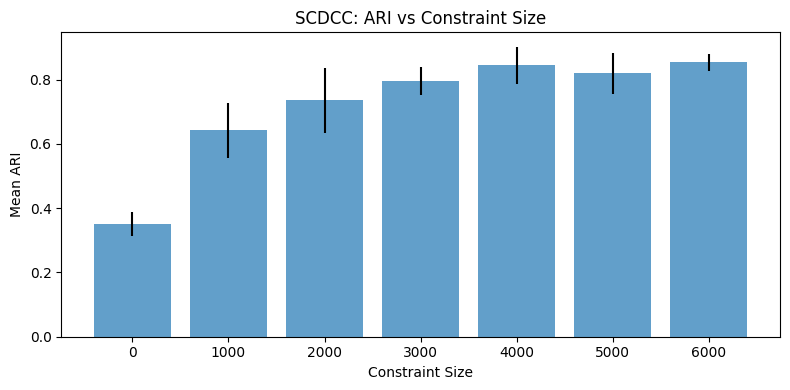

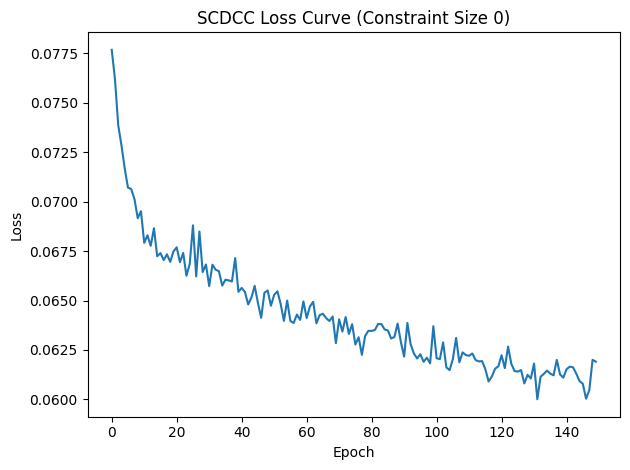

=== Visualizing constraint size: 0 ===


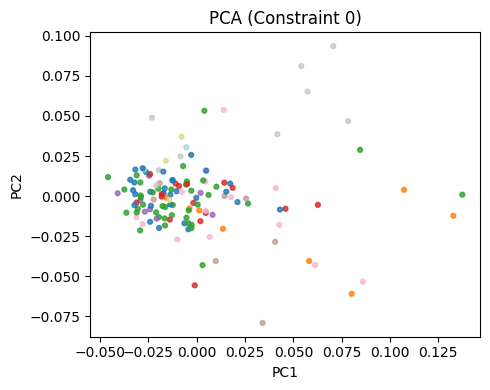

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


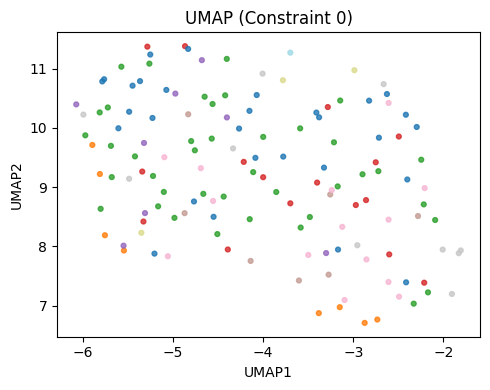

=== Visualizing constraint size: 1000 ===


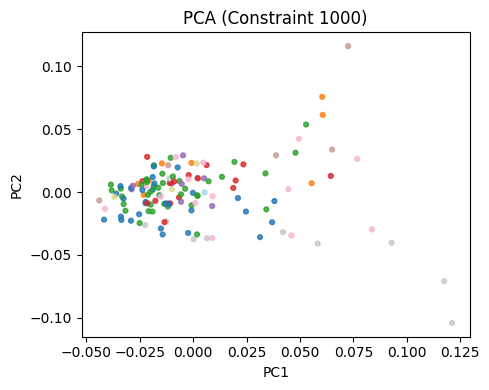

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


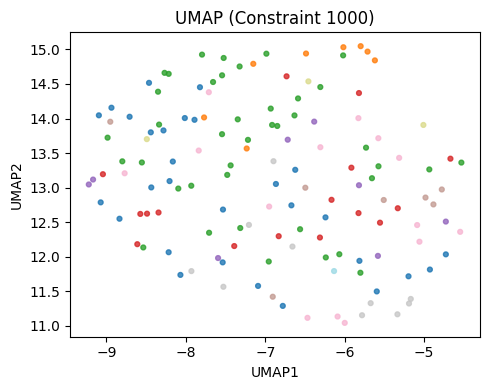

=== Visualizing constraint size: 2000 ===


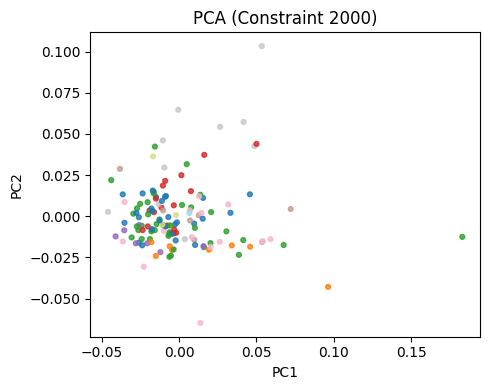

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


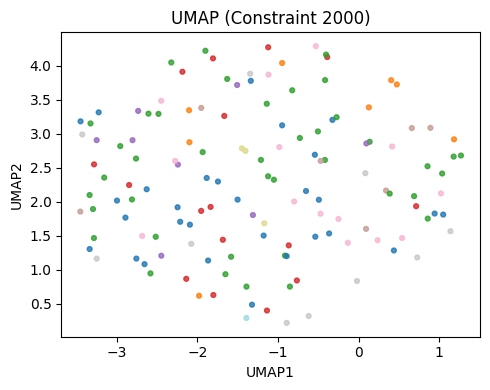

=== Visualizing constraint size: 3000 ===


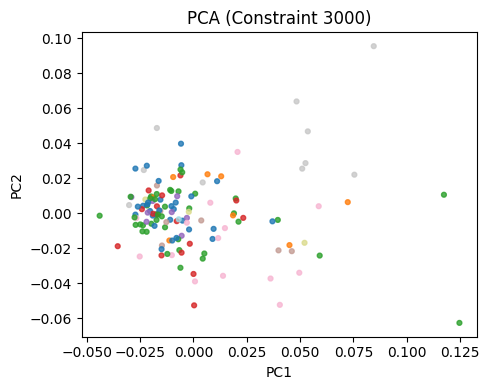

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


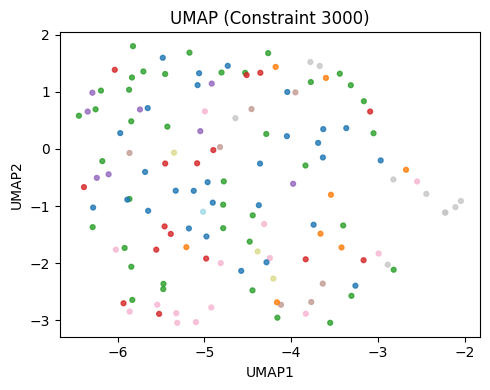

=== Visualizing constraint size: 4000 ===


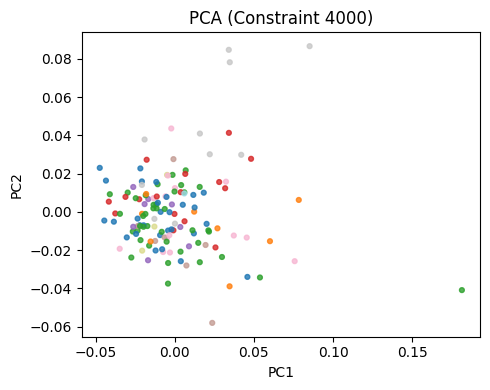

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


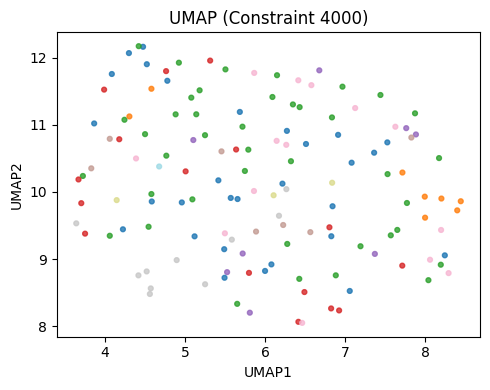

=== Visualizing constraint size: 5000 ===


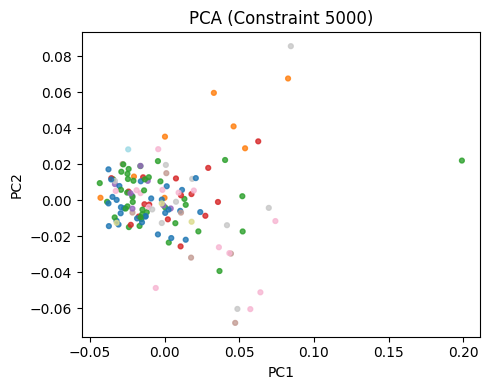

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


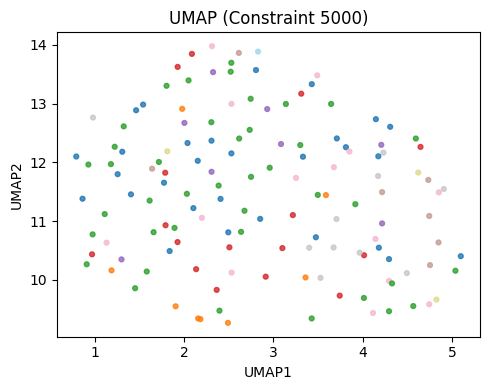

=== Visualizing constraint size: 6000 ===


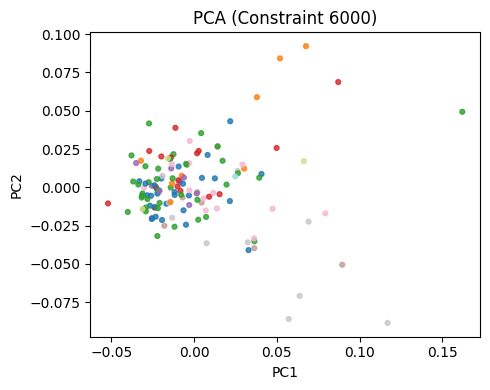

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


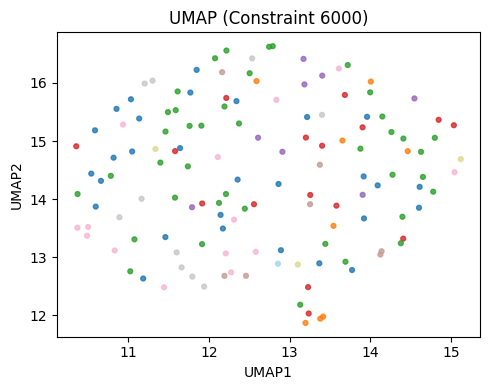

In [14]:
#  Preparing arrays from AnnData objects 
X_train = adata_raw_train.X.astype(np.float32)
X_val   = adata_raw_val.X.astype(np.float32)
X_test  = adata_raw_test.X.astype(np.float32)
y_train = adata_raw_train.obs["label"].astype(int).values
y_val   = adata_raw_val.obs["label"].astype(int).values
y_test  = adata_raw_test.obs["label"].astype(int).values

# Remaping constraints 
cellname_to_idx = {name: i for i, name in enumerate(adata_raw_train.obs_names)}
def remap_pairs(pairs, mapping):
    return [(mapping[i], mapping[j]) for i, j in pairs if i in mapping and j in mapping]

constraints_idx = {
    size: {
        'must_link': remap_pairs(v['must_link'], cellname_to_idx),
        'cannot_link': remap_pairs(v['cannot_link'], cellname_to_idx)
    }
    for size, v in constraints.items()
}

#Runing SCDCC 
middle_idx = len(constraints_idx) // 2
results = run_full_scdcc_pipeline(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    constraints_idx,
    latent_dims=[10, 20, 50],
    lrs=[1e-3, 5e-4],
    pretrain_epochs=300,
    train_epochs=150,
    n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0,
    tune_constraint_index=middle_idx    # <---- FIXED: No error now!
)

#  results 
import pandas as pd
df = pd.DataFrame(results).T
display(df)

#  Ploting ARI mean vs constraint size
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(df.index.astype(str), df["ARI_mean"], yerr=df["ARI_std"], alpha=0.7, label='ARI')
plt.title("SCDCC: ARI vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Mean ARI")
plt.tight_layout()
plt.show()

# Ploting training loss curve 
first_size = list(results.keys())[0]
plt.plot(results[first_size]['loss_curves'][0])
plt.title(f'SCDCC Loss Curve (Constraint Size {first_size})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# 2D PCA/UMAP/Latent Visualization for Each Constraint Size 
from sklearn.decomposition import PCA
import umap

for size in results:
    print(f"=== Visualizing constraint size: {size} ===")
    # We'll just run a model again to get embeddings. You can save them during training if you want.
    model = scDCC(input_dim=X_train.shape[1], latent_dim=20).to(device)
    model.eval()
    with torch.no_grad():
        _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
    z_test = z_test.cpu().numpy()

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"PCA (Constraint {size})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    z_umap = reducer.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_umap[:,0], z_umap[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"UMAP (Constraint {size})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()




In [15]:
#  SCDCC mean ± std from best constraint size:
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

# KMeans and DEC values:
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


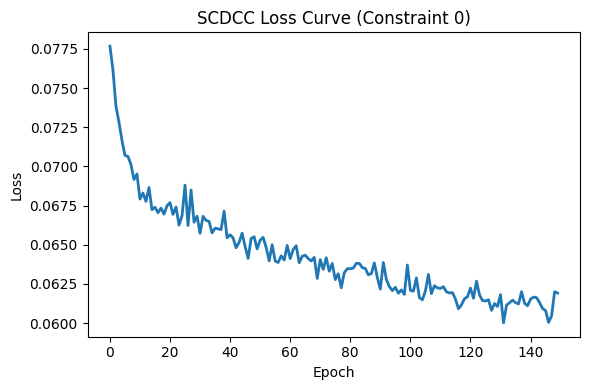

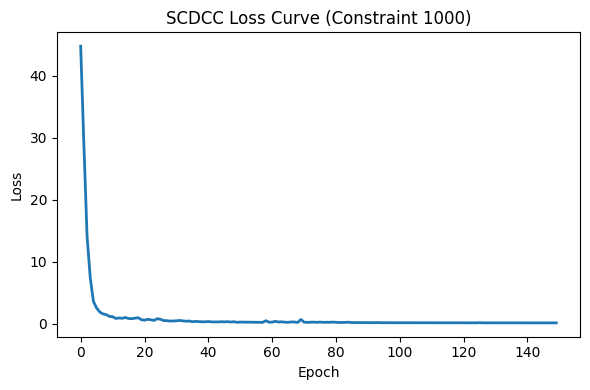

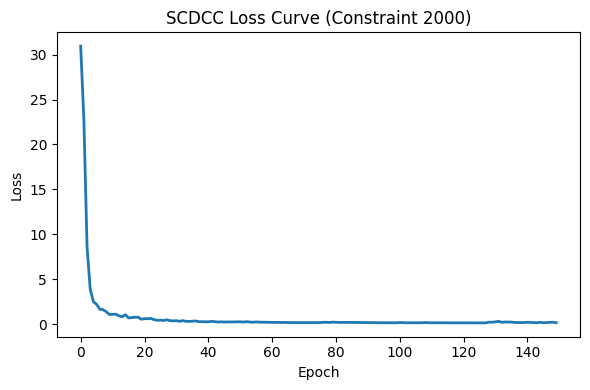

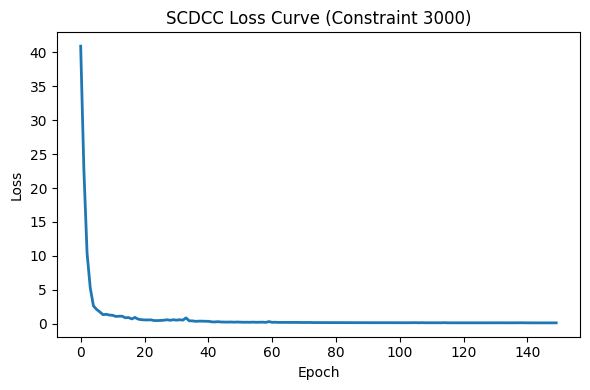

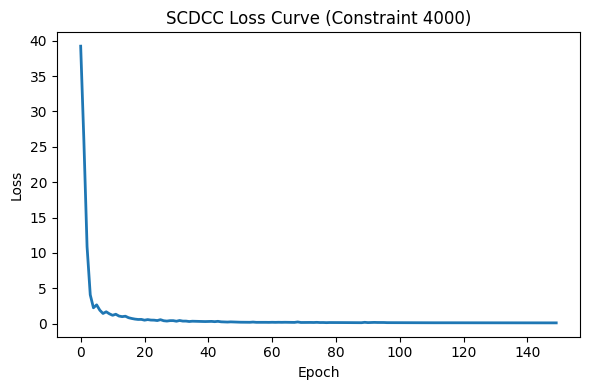

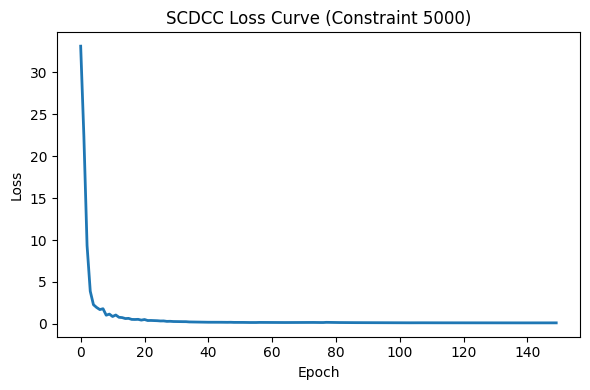

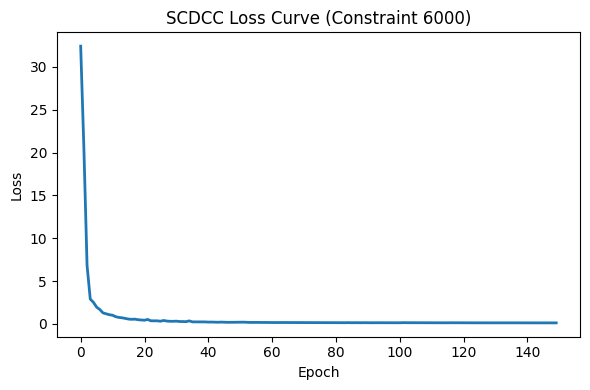

In [16]:
for size in results:
    loss_curve = results[size]['loss_curves'][0]  
    plt.figure(figsize=(6,4))
    plt.plot(loss_curve, lw=2)
    plt.title(f"SCDCC Loss Curve (Constraint {size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()


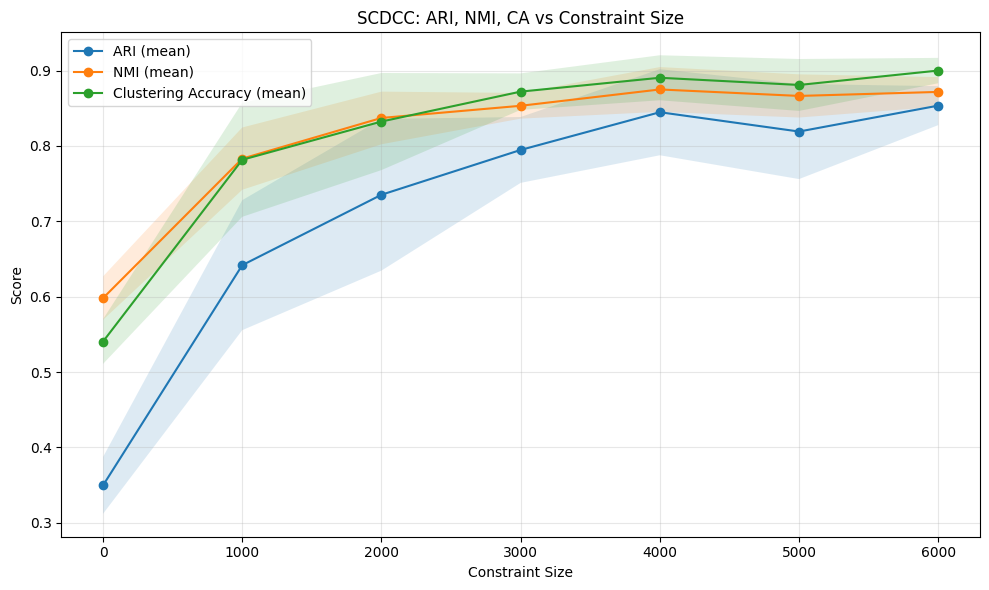

In [17]:
#plotting line graph

metrics = [
    ("ARI_mean", "ARI_std", "ARI"),
    ("NMI_mean", "NMI_std", "NMI"),
    ("CA_mean",  "CA_std",  "Clustering Accuracy"),
]

sizes = list(results.keys())
sizes_int = [int(s) for s in sizes]
sort_idx = np.argsort(sizes_int)
sorted_sizes = [sizes[i] for i in sort_idx]
size_ticks = [int(s) for s in sorted_sizes]

plt.figure(figsize=(10, 6))
for mean_key, std_key, display_name in metrics:
    means = [results[s][mean_key] for s in sorted_sizes]
    stds  = [results[s][std_key]  for s in sorted_sizes]
    plt.plot(size_ticks, means, marker='o', label=f"{display_name} (mean)")
    plt.fill_between(size_ticks,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.15)

plt.title("SCDCC: ARI, NMI, CA vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Score")
plt.xticks(size_ticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


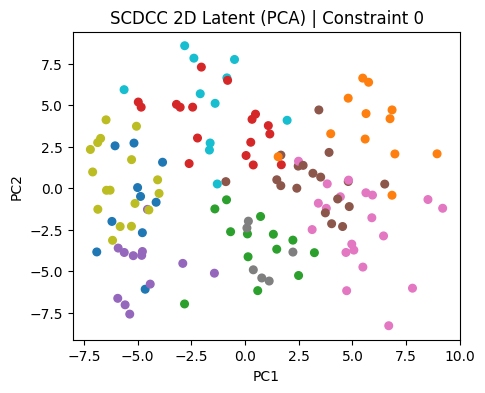

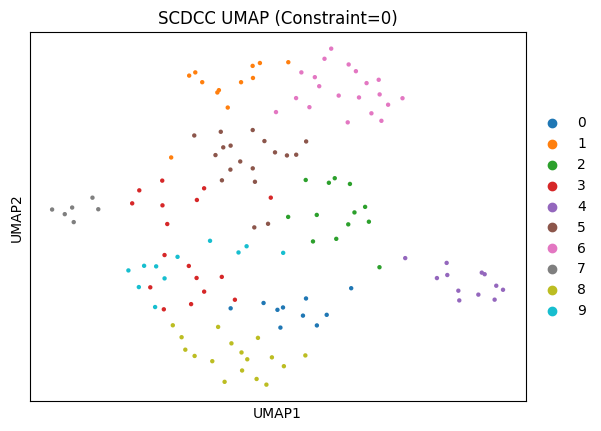

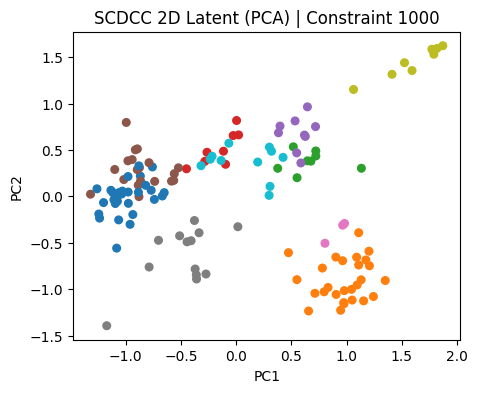

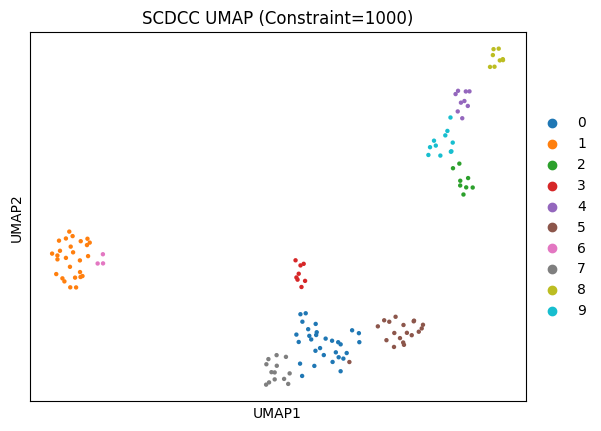

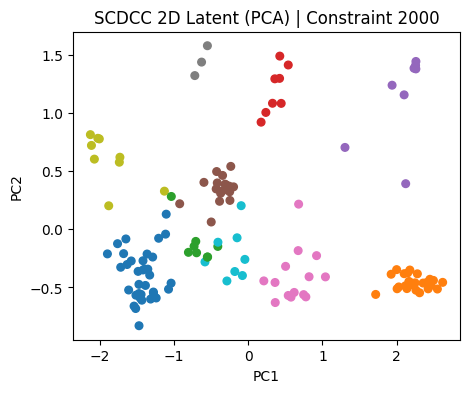

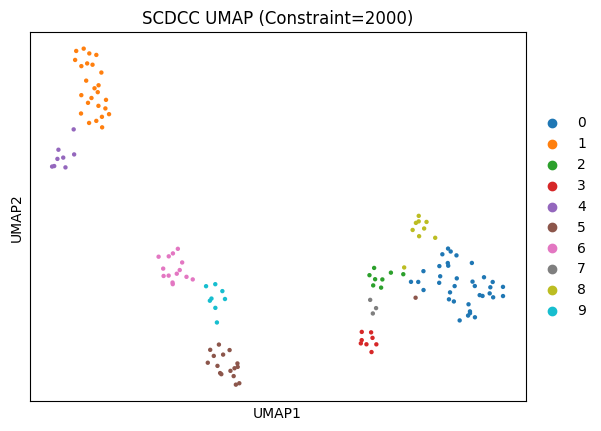

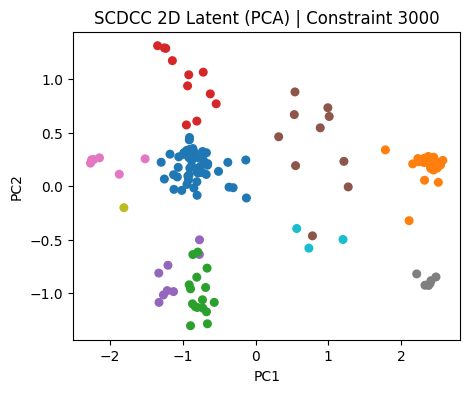

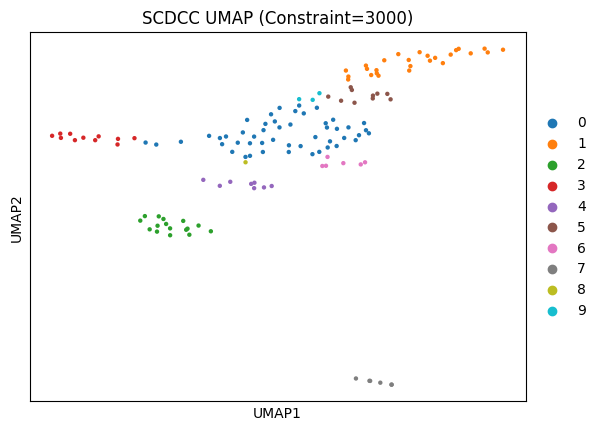

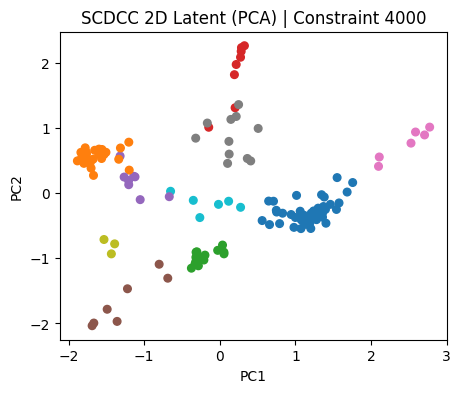

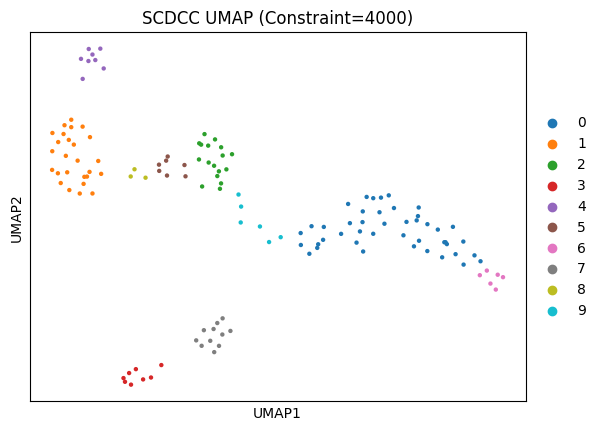

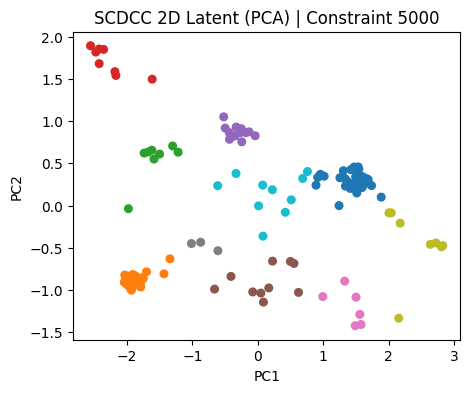

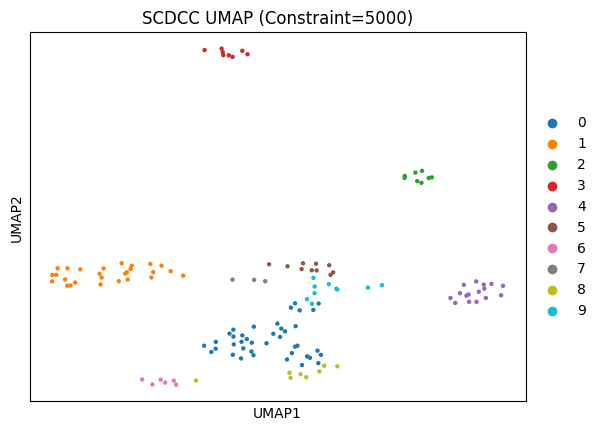

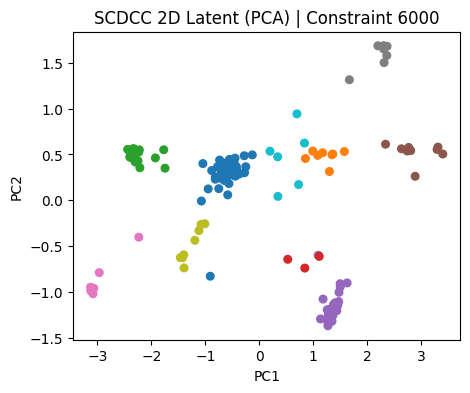

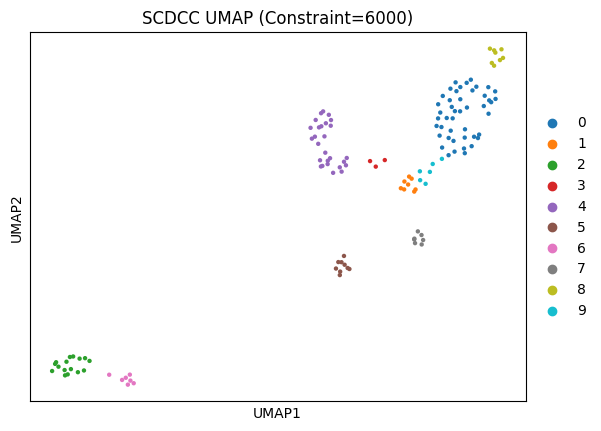

In [18]:


# For each constraint size showing 2D PCA and UMAP for the first run
for size in results:
    z_test = results[size]['z_tests'][0]
    preds = results[size]['test_preds'][0]

    # 2D PCA
    z_2d = PCA(n_components=2).fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='tab10', s=30)
    plt.title(f"SCDCC 2D Latent (PCA) | Constraint {size}")
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

    # UMAP
    adata = sc.AnnData(z_test)
    adata.obs['cluster'] = pd.Categorical(preds.astype(str))
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cluster', title=f"SCDCC UMAP (Constraint={size})", size=40)


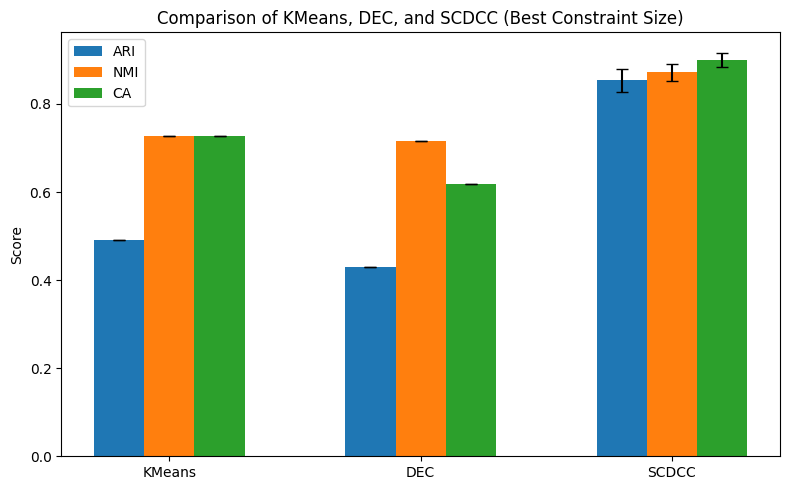

In [19]:

# bar plot Visualisation
methods = ['KMeans', 'DEC', 'SCDCC']
ari_scores = [kmeans_ari, dec_ari, scdcc_ari]
ari_errs = [0, 0, scdcc_ari_std]  # only SCDCC has std (if you want to plot it)
nmi_scores = [kmeans_nmi, dec_nmi, scdcc_nmi]
nmi_errs = [0, 0, scdcc_nmi_std]
ca_scores = [kmeans_ca, dec_ca, scdcc_ca]
ca_errs = [0, 0, scdcc_ca_std]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width, ari_scores, width, yerr=ari_errs, capsize=4, label='ARI')
plt.bar(x, nmi_scores, width, yerr=nmi_errs, capsize=4, label='NMI')
plt.bar(x + width, ca_scores, width, yerr=ca_errs, capsize=4, label='CA')
plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Comparison of KMeans, DEC, and SCDCC (Best Constraint Size)")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:

#summary of results
summary = pd.DataFrame({
    'ARI': ari_scores,
    'NMI': nmi_scores,
    'CA': ca_scores
}, index=methods)

# Optionally include standard deviations
summary_std = pd.DataFrame({
    'ARI': ari_errs,
    'NMI': nmi_errs,
    'CA': ca_errs
}, index=methods)

print("=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===")
print(summary)
if any(s > 0 for s in ari_errs + nmi_errs + ca_errs):
    print("\n(Standard deviations where available):")
    print(summary_std)


=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===
             ARI       NMI        CA
KMeans  0.490788  0.727463  0.727941
DEC     0.429388  0.716401  0.617647
SCDCC   0.853464  0.871659  0.900000

(Standard deviations where available):
             ARI       NMI        CA
KMeans  0.000000  0.000000  0.000000
DEC     0.000000  0.000000  0.000000
SCDCC   0.025862  0.019665  0.016832
